In [51]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [52]:
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
import importlib
import models
importlib.reload(models)
from models import LiteralListener, LiteralSpeaker, PragmaticListener, CaptionEncoder, CaptionGenerator, PytorchModel, ColorEncoder
# from evaluation import score_model
from experiment import FeatureHandler#, evaluate_model
from scipy import stats # for pearsonr, spearmanr

In [53]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [54]:
eval_df = None
def score_model(test_data, scores, regressor=stats.pearsonr):
    """
    Assume scores are in the same order as the test data (i.e. 0th row is 0th score) and calculates a regression
    between the scores of the individual games and the scores from the model
    """
    global eval_df
    relevant_columns = ["gameid", "roundNum", "numOutcome", "workerid_uniq", "condition"]
#     if speaker == Speaker.BY_WORKER_ID:
#         relevant_columns.append(Speaker.BY_WORKER_ID.value)

# #     if score == Score.COMPOSITE:
#         # no support for this yet but probably also need:
#         relevant_columns.extend(["contents", "clkTime", "msgTime"])

    eval_df = test_data.data[relevant_columns].copy()
    eval_df["model_scores"] = scores # why we need scores to be in same order as rows

    #true_scores = eval_df.groupby("gameid").numOutcome.mean()
    true_scores = eval_df.groupby("gameid").numOutcome.mean()


#     if score == score.SIMPLE:
#         # calculate scores as the mean of the number of successful utterances
#         # a speaker has
#         true_scores = eval_df.groupby(speaker.value).numOutcome.mean()
#     else:
#         true_scores = calculate_scores(eval_df, score)

    # calculate a model score
    #model_scores = eval_df.groupby("gameid").model_scores.mean()
    model_scores = eval_df.groupby("gameid").model_scores.mean()

    result = regressor(true_scores, model_scores)
    return result, true_scores, model_scores

In [55]:
def evaluate_model(assess_data, feature_handler, model, predictions_to_scores, model_scorer=score_model,
                    model_scorer_kwargs={}, accuracy=True):
    assess_features = feature_handler.test_features() # ~6 sec
    assess_targets = feature_handler.test_targets()
    model_outputs =  model.predict(assess_features)
    model_scores = predictions_to_scores(model_outputs, assess_targets) # decide what the score we're going to use is
    result, true_scores_grouped, model_scores_grouped = model_scorer(assess_data, model_scores, **model_scorer_kwargs)
    print(result)

    if accuracy: # also report accuracy
        model_predictions = np.argmax(model_outputs, axis=1)
        accuracy_val = sum(model_predictions == assess_targets) / len(assess_targets)
        print("Accuracy:", accuracy_val)
        
    return assess_targets, model_outputs, model_scores, true_scores_grouped, model_scores_grouped

In [56]:
# Literal Listener v2

# Initializing featurizers
print("Initializing featurizers")
caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn` - using endings tokenizer to separate endings like "ish" and "er"
# caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.WhitespaceTokenizer) # Use with other paremter files

color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)

# Now we have a different target function, because we want to predict what the listener selected
def listener_click_target(data_entry, color_perm):
    # color_perm because colors are randomized
    return np.where(color_perm==data_entry.click_idx)[0]

feature_handler = FeatureHandler(train_data, dev_data, caption_phi, color_phi, target_fn=listener_click_target)

print("Obtaining training features") # get features even if you're runnning the pretrained model for example
train_features = feature_handler.train_features()
train_targets = feature_handler.train_targets()

print("Initializing model")
# model parameters
embed_dim = 100; hidden_dim = 100; color_dim= 54; # hard coded for example - 54 comes from color fourier phi




Initializing featurizers
Obtaining training features
Initializing model


In [57]:
train = False
model_file_v2 = "../model/literal_listener_listener_click_5epoch_endings_tkn.params"

model_v2 = LiteralListener(CaptionEncoder, num_epochs=30)
model_v2.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file_v2))
    model_v2.fit(train_features, train_targets)
    model_v2.save_model(model_file_v2)
else:
    print("Loading pretrained model")
    model_v2.load_model(model_file_v2)

Loading pretrained model


In [58]:
# accuracy doesn't matter too much here bc it's trained to pick listener click and tested against speaker target
print("Evaluating model - Literal Listener Listener Click\t Target: speaker target")
output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score

# we want to score based on the model's predictions at the TARGET indices not listener clicked indices,
# so we change the feature_handler's target function to do that:
feature_handler.target_fn = lambda data_entry, color_perm: np.where(color_perm == data_entry.target_idx)[0]
assess_targets_tgt_v2, model_outputs_v2, model_scores_v2, true_scores_grouped_v2, model_scores_grouped_v2 =\
    evaluate_model(dev_data, feature_handler, model_v2, output_to_score, score_model)

Evaluating model - Literal Listener Listener Click	 Target: speaker target
(0.26503235158369626, 1.7015266264443892e-06)
Accuracy: 0.711104020421187


In [59]:
import matplotlib.pyplot as plt

In [60]:
%matplotlib inline

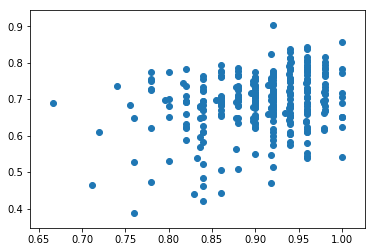

In [61]:
plt.scatter(true_scores_grouped_v2, model_scores_grouped_v2)

In [28]:
eval_scores_split = eval_df.groupby(['gameid', 'condition']).mean()

In [29]:
eval_scores_split['model_scores']

gameid  condition
0022-7  close        0.819281
        far          0.993690
        split        0.497969
0069-8  close        0.770173
        far          0.778668
        split        0.604926
0070-1  close        0.553876
        far          0.799863
        split        0.629733
0106-1  close        0.758744
        far          0.842995
        split        0.870811
0109-c  close        0.748182
        far          0.986452
        split        0.819455
0137-f  close        0.540230
        far          0.875983
        split        0.567394
0197-6  close        0.743527
        far          0.938014
        split        0.751870
0217-e  close        0.708487
        far          0.961938
        split        0.761597
0219-7  close        0.712412
        far          0.947332
        split        0.953094
0239-7  close        0.784983
        far          0.998048
        split        0.730621
                       ...   
9709-7  close        0.820042
        far          0

In [30]:
eval_scores_split['numOutcome']

gameid  condition
0022-7  close        0.933333
        far          1.000000
        split        0.882353
0069-8  close        1.000000
        far          1.000000
        split        0.882353
0070-1  close        0.687500
        far          0.941176
        split        0.705882
0106-1  close        0.937500
        far          0.941176
        split        0.764706
0109-c  close        0.882353
        far          1.000000
        split        1.000000
0137-f  close        0.882353
        far          0.941176
        split        0.937500
0197-6  close        0.875000
        far          1.000000
        split        0.882353
0217-e  close        1.000000
        far          1.000000
        split        1.000000
0219-7  close        0.647059
        far          1.000000
        split        0.941176
0239-7  close        0.941176
        far          1.000000
        split        1.000000
                       ...   
9709-7  close        0.941176
        far          1

In [44]:
eval_scores_split.index.get_level_values(1).values

array(['close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'close', 'far', 'split', 'close',
       'far', 'split', 'close', 'far', 'split', 'close', 'far', 'split',
       'close', 'far', 'split', 'close', 'far', 'split', 'close', 'far',
       'split', 'close', 'far', 'split', 'c

In [47]:
colors = []
for cond in eval_scores_split.index.get_level_values(1).values:
    if cond == 'close':
        colors.append('red')
    elif cond == 'split':
        colors.append('blue')
    else:
        colors.append('green')

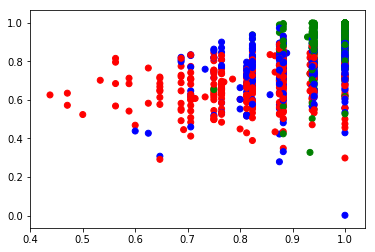

In [48]:
plt.scatter(eval_scores_split['numOutcome'], eval_scores_split['model_scores'], c=colors)
plt.show()

In [ ]:
eval_scores_split['condition']

In [57]:
close_scores = eval_df[eval_df['condition'] == 'close'].groupby('gameid').mean()
split_scores = eval_df[eval_df['condition'] == 'split'].groupby('gameid').mean()
far_scores = eval_df[eval_df['condition'] == 'far'].groupby('gameid').mean()

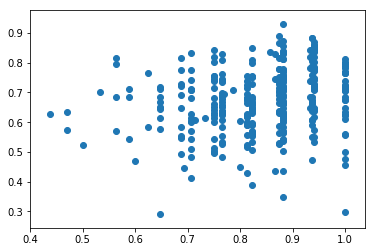

In [130]:
plt.scatter(close_scores['numOutcome'], close_scores['model_scores'])
plt.show()

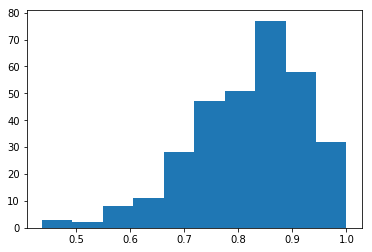

In [129]:
plt.hist(close_scores['numOutcome'], 10)
plt.show()

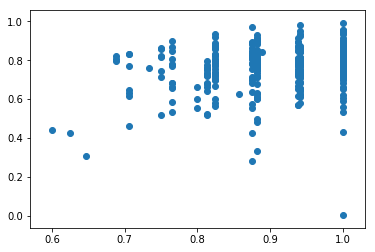

In [63]:
plt.scatter(split_scores['numOutcome'], split_scores['model_scores'])
plt.show()

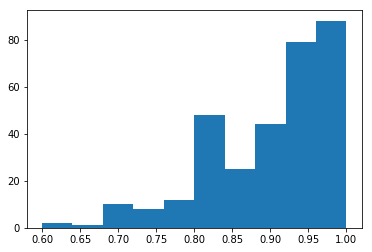

In [132]:
plt.hist(split_scores['numOutcome'], 10)
plt.show()

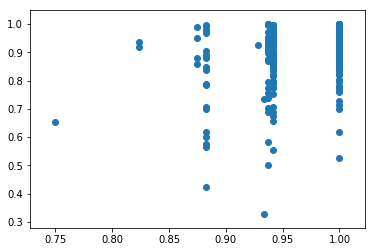

In [64]:
plt.scatter(far_scores['numOutcome'], far_scores['model_scores'])
plt.show()

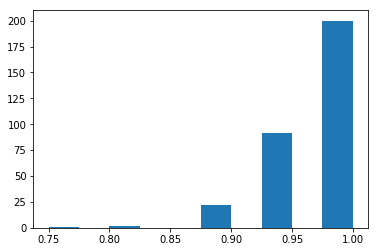

In [134]:
plt.hist(far_scores['numOutcome'], 10)
plt.show()

In [53]:
5171*3

15513

In [65]:
import pandas as pd

In [66]:
subj_analysis_df = pd.read_csv("/Users/benjaminnewman/Documents/Stanford/CS224U/projects/colors-in-context/behavioralAnalysis/humanOutput/rawCorpus/subjectInfo.csv")

In [71]:
subj_analysis_df.head()

,workerid,totalLength,gameID,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
0,0,572478,3843-c,yes,yes,NaN,loved,listener,yes,NaN
1,1,535364,7555-2,yes,yes,NaN,okay,listener,yes,NaN
2,2,664826,3540-a,yes,yes,NaN,liked,speaker,yes,NaN
3,3,1083450,9346-5,yes,yes,NaN,liked,speaker,yes,NaN
4,4,1070736,9346-5,yes,yes,i loved this hit!!!,loved,listener,yes,NaN


In [69]:
subj_analysis_df.ratePartner.value_counts()

loved       839
liked       635
okay        425
not much    162
Name: ratePartner, dtype: int64

In [82]:
subj_analysis_df.gameID.value_counts()

6765-6    2
3788-d    2
3671-d    2
3603-b    2
9993-d    2
3720-1    2
7209-c    2
5419-7    2
3938-b    2
3412-4    2
1184-f    2
4391-a    2
3661-0    2
2166-8    2
5080-2    2
3864-c    2
2427-e    2
1856-c    2
7859-5    2
4655-f    2
6433-2    2
3147-1    2
9713-c    2
7636-7    2
1928-6    2
3466-0    2
4517-7    2
9191-c    2
2722-7    2
7912-7    2
         ..
4616-b    1
2965-7    1
1179-b    1
8802-8    1
3556-8    1
9501-2    1
5185-7    1
7845-0    1
1892-a    1
7182-5    1
5063-f    1
8141-d    1
1707-e    1
7871-d    1
7018-f    1
1971-7    1
6510-b    1
0573-1    1
7224-2    1
7331-8    1
4629-a    1
2927-4    1
9734-1    1
7383-8    1
4141-e    1
3659-9    1
9417-8    1
6914-7    1
8086-b    1
7112-9    1
Name: gameID, Length: 1119, dtype: int64

In [74]:
overlap_vals = []
for gameid in subj_analysis_df['gameID']:
    overlap_vals.append(gameid in eval_df.gameid.values)

In [77]:
sum(overlap_vals)/len(overlap_vals)

0.30072639225181597

In [81]:
len(overlap_vals)

2065

In [215]:
subj_analysis_subdf2 = subj_analysis_df[(overlap_vals)]

In [86]:
subj_analysis_subdf.shape

(310, 10)

In [89]:
close_scores.shape

(317, 4)

In [94]:
close_games_subj = close_scores.join(subj_analysis_subdf.set_index('gameID'))

In [95]:
close_games_subj.head()

,roundNum,numOutcome,workerid_uniq,model_scores,workerid,totalLength,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
gameid,,,,,,,,,,,,,
0022-7,26.733333,0.933333,223.0,0.819281,1853.0,1333365.0,yes,yes,thank you!,loved,listener,yes,46.0
0069-8,24.937500,1.000000,324.0,0.770173,1759.0,663384.0,yes,yes,NaN,loved,listener,yes,48.0
0070-1,25.375000,0.687500,324.0,0.553876,1502.0,905350.0,yes,yes,NaN,loved,listener,yes,39.0
0106-1,24.312500,0.937500,325.0,0.758744,369.0,677364.0,yes,yes,Great experiment!,loved,listener,yes,44.0
0109-c,27.588235,0.882353,232.0,0.748182,1615.0,1068382.0,yes,yes,"More, more, more!!!",loved,listener,yes,48.0


In [99]:
close_games_subj.ratePartner.value_counts(dropna=False)

loved       134
liked        91
okay         62
not much     23
NaN           7
Name: ratePartner, dtype: int64

In [98]:
134+91+62+23

310

In [115]:
rate_partner_colors = []
colmap={'loved':'red', 'liked':'green', 'okay':'blue', 'not much':'purple'}
#colmap={'loved':'white', 'liked':'white', 'okay':'blue', 'not much':'white'}
for rating in close_games_subj.ratePartner.values:
    rate_partner_colors.append(colmap.get(rating, 'black'))

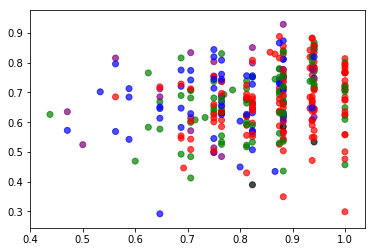

In [116]:
plt.scatter(close_games_subj['numOutcome'], close_games_subj['model_scores'], c=rate_partner_colors, alpha=0.7)
plt.show()

In [117]:
split_games_subj = split_scores.join(subj_analysis_subdf.set_index('gameID'))

In [120]:
rate_partner_colors_split = []
colmap={'loved':'red', 'liked':'green', 'okay':'blue', 'not much':'purple'}
#colmap={'loved':'white', 'liked':'white', 'okay':'blue', 'not much':'white'}
for rating in split_games_subj.ratePartner.values:
    rate_partner_colors_split.append(colmap.get(rating, 'black'))

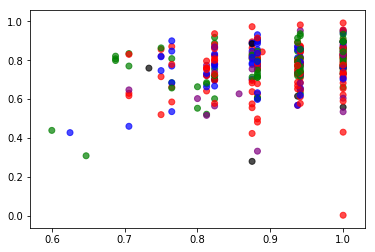

In [122]:
plt.scatter(split_games_subj['numOutcome'], split_games_subj['model_scores'], c=rate_partner_colors_split, alpha=0.7)
plt.show()

In [124]:
far_games_subj = far_scores.join(subj_analysis_subdf.set_index('gameID'))

In [125]:
rate_partner_colors_far = []
colmap={'loved':'red', 'liked':'green', 'okay':'blue', 'not much':'purple'}
#colmap={'loved':'white', 'liked':'white', 'okay':'blue', 'not much':'white'}
for rating in far_games_subj.ratePartner.values:
    rate_partner_colors_far.append(colmap.get(rating, 'black'))

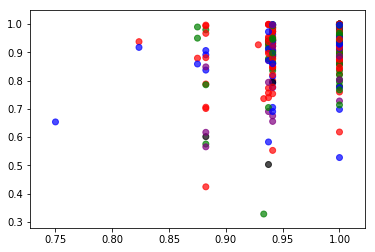

In [126]:
plt.scatter(far_games_subj['numOutcome'], far_games_subj['model_scores'], c=rate_partner_colors_far, alpha=0.7)
plt.show()

In [135]:
far_games_subj.index.get_level_values('gameid')

,roundNum,numOutcome,workerid_uniq,model_scores,workerid,totalLength,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
gameid,,,,,,,,,,,,,
0022-7,25.352941,1.000000,223.0,0.993690,1853.0,1333365.0,yes,yes,thank you!,loved,listener,yes,46.0
0069-8,31.647059,1.000000,324.0,0.778668,1759.0,663384.0,yes,yes,NaN,loved,listener,yes,48.0
0070-1,27.117647,0.941176,324.0,0.799863,1502.0,905350.0,yes,yes,NaN,loved,listener,yes,39.0
0106-1,22.470588,0.941176,325.0,0.842995,369.0,677364.0,yes,yes,Great experiment!,loved,listener,yes,44.0
0109-c,23.529412,1.000000,232.0,0.986452,1615.0,1068382.0,yes,yes,"More, more, more!!!",loved,listener,yes,48.0


In [137]:
far_games_subj.index.get_level_values('gameid')

Index(['0022-7', '0069-8', '0070-1', '0106-1', '0109-c', '0137-f', '0197-6',
       '0217-e', '0219-7', '0239-7',
       ...
       '9709-7', '9714-3', '9719-9', '9776-7', '9841-e', '9850-2', '9922-e',
       '9946-1', '9947-c', '9973-5'],
      dtype='object', name='gameid', length=317)

In [139]:
subj_analysis_subdf[subj_analysis_subdf.gameID == "1925-1"]

,workerid,totalLength,gameID,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
406,194,2070027,1925-1,yes,yes,nice to work,liked,listener,yes,33.0


In [146]:
subj_analysis_df[subj_analysis_df.gameID == "1925-1"]["comments"][468]

'I actually really like this. My partner seemed occupied elsewhere'

In [148]:
subj_analysis_df[subj_analysis_df.gameID == "3332-5"]

,workerid,totalLength,gameID,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
1766,1554,719264,3332-5,yes,yes,NaN,liked,speaker,yes,37.0
1810,1598,621159,3332-5,yes,yes,NaN,not much,listener,yes,37.0


In [149]:
subj_analysis_df[subj_analysis_df.gameID == "7286-9"]

,workerid,totalLength,gameID,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
222,10,837496,7286-9,yes,yes,NaN,okay,listener,yes,36.0
385,173,820606,7286-9,yes,yes,better pay next time!,okay,speaker,yes,36.0


In [151]:
subj_analysis_df[subj_analysis_df.gameID == "0069-8"]


,workerid,totalLength,gameID,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
1857,1645,754928,0069-8,yes,yes,Fun Experiment!,liked,speaker,yes,48.0
1971,1759,663384,0069-8,yes,yes,NaN,loved,listener,yes,48.0


In [154]:
subj_analysis_subdf.ratePartner.value_counts()

loved       134
liked        91
okay         62
not much     23
Name: ratePartner, dtype: int64

In [155]:
subj_analysis_df[subj_analysis_df.role=='speaker'].ratePartner.value_counts()

loved       429
liked       331
okay        211
not much     57
Name: ratePartner, dtype: int64

In [156]:
subj_analysis_df[subj_analysis_df.role=='listener'].ratePartner.value_counts()

loved       410
liked       304
okay        214
not much    105
Name: ratePartner, dtype: int64

In [201]:
bad_gameids = subj_analysis_df[(subj_analysis_df.role=="speaker") & (subj_analysis_df.ratePartner=="not much")].gameID.values

In [202]:
bad_gameids

array(['9666-b', '4845-7', '0813-a', '6719-f', '8497-4', '1034-2',
       '8569-c', '5777-0', '1404-9', '4992-e', '7040-8', '3904-b',
       '6856-2', '1925-1', '5557-c', '2052-9', '7085-3', '0836-2',
       '9348-d', '6325-a', '5604-e', '0215-2', '3682-7', '7286-3',
       '2066-9', '5801-8', '5185-7', '3556-8', '9501-2', '7034-b',
       '0696-f', '9734-1', '7990-0', '0082-f', '4607-0', '5420-f',
       '9925-0', '6510-b', '8912-f', '2200-3', '3802-d', '4928-6',
       '3639-a', '3660-d', '6421-c', '1830-a', '3464-e', '8772-f',
       '7174-e', '2273-b', '2679-a', '9850-2', '6903-c', '1033-9',
       '1274-7', '7435-7', '5418-2'], dtype=object)

In [203]:
good_dev_data = ~dev_data.data.gameid.isin(bad_gameids)

In [204]:
good_values = dev_data.data[good_dev_data].index.values

In [205]:
dev_data_good = dev_data.data[good_dev_data]

In [206]:
dev_data_good_entries = []
for val in good_values:
    dev_data_good_entries.append(dev_data.entries[val])

In [207]:
dev_data_good_entries[:2]

[gray, green]

In [208]:
feature_handler_2 = FeatureHandler(train_data, dev_data_good_entries, caption_phi, color_phi)



In [198]:
len(dev_data.data.index.values)

15670

In [199]:
class dummy:
    def __init__(self, data):
        self.data=data

In [209]:
x = evaluate_model(dummy(dev_data_good), feature_handler_2, model_v2, output_to_score, score_model, accuracy=True)

(0.3365427827892697, 1.4481133298029342e-09)
Accuracy: 0.7954919923548408


In [185]:
assess_targets_tgt_v2_good, model_outputs_v2_good, model_scores_v2_good, true_scores_grouped_v2_good, model_scores_grouped_v2_good = x

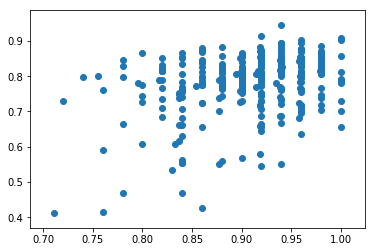

In [186]:
plt.scatter(true_scores_grouped_v2_good, model_scores_grouped_v2_good)

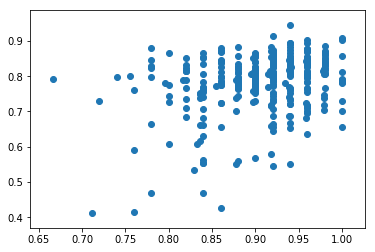

In [187]:
plt.scatter(true_scores_grouped_v2, model_scores_grouped_v2)

In [219]:
subj_analysis_subdf2.head()

,workerid,totalLength,gameID,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
213,1,751649,3676-4,yes,yes,It was very interesting,loved,listener,yes,45.0
214,2,709593,8295-7,yes,yes,that&quotechars a fun experiment!,loved,speaker,yes,43.0
215,3,1358867,8351-5,yes,yes,thanks for the interesting study,liked,speaker,yes,46.0
218,6,1442982,7328-c,yes,yes,Very fun!,liked,speaker,yes,48.0
222,10,837496,7286-9,yes,yes,NaN,okay,listener,yes,36.0


In [222]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="not much")].score)

43.391304347826086

In [223]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="loved")].score)

46.09701492537314

In [224]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="okay")].score)

43.774193548387096

In [225]:
np.mean(subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="liked")].score)

45.21978021978022

In [228]:
subj_analysis_subdf2[(subj_analysis_subdf2.role=="listener") & (subj_analysis_subdf2.ratePartner=="not much")]

,workerid,totalLength,gameID,thinksHuman,confused,comments,ratePartner,role,nativeEnglish,score
249,37,609692,0767-f,yes,yes,NaN,not much,listener,yes,44.0
324,112,724861,0716-6,yes,yes,NaN,not much,listener,yes,47.0
341,129,1233423,4860-7,yes,yes,I don&quotechart know if my partner had differ...,not much,listener,yes,42.0
343,131,1187596,2639-b,yes,yes,a calibration step to have everyone pick green...,not much,listener,yes,39.0
352,140,885425,6856-2,yes,yes,"I could tell this person was a woman. Also, I ...",not much,listener,yes,46.0
450,238,1462536,5759-a,yes,yes,"Thanks, partner was slow, took twice as long a...",not much,listener,yes,45.0
630,418,1434931,7328-c,yes,yes,NaN,not much,listener,yes,48.0
647,435,547384,2136-2,yes,yes,NaN,not much,listener,yes,44.0
656,444,756178,0219-7,no,yes,I liked this hit quite a lot and would love to...,not much,listener,yes,43.0
668,456,946321,8972-7,yes,yes,NaN,not much,listener,yes,43.0


In [235]:
subj_analysis_subdf2["comments"][343]

'a calibration step to have everyone pick green most and blue most and grey most would be good information to have. I think I was led astry a few times in this round. would like to see more positive indication if I got a choice wrong. I see a black square that quickly turns green so I have no idea.\nmaybe it&quotechars intentional to keep the listener guessing?\n'

8432) Game: 0767-f Round: 1
plum


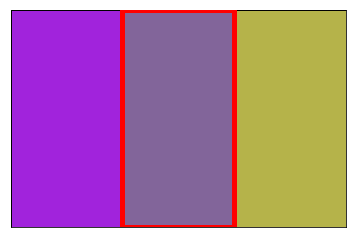

8433) Game: 0767-f Round: 2
flamingo


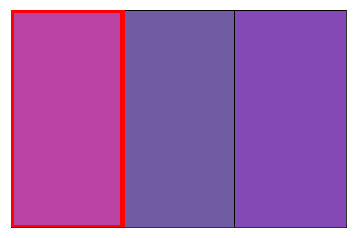

8434) Game: 0767-f Round: 3
bluish green


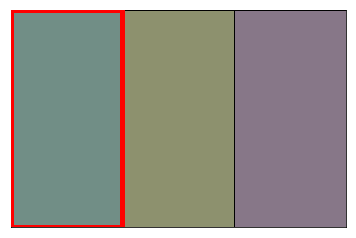

8435) Game: 0767-f Round: 4
lime


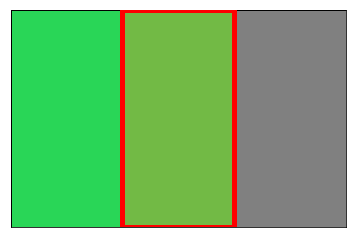

8436) Game: 0767-f Round: 5
bluish green


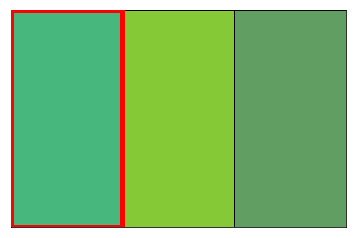

8437) Game: 0767-f Round: 6
apple


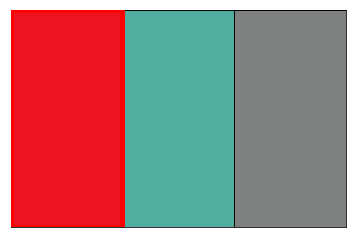

8438) Game: 0767-f Round: 7
grape


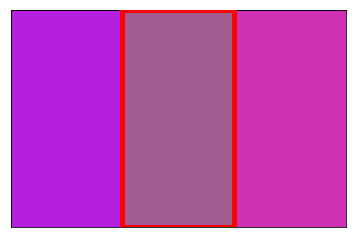

8439) Game: 0767-f Round: 8
sky


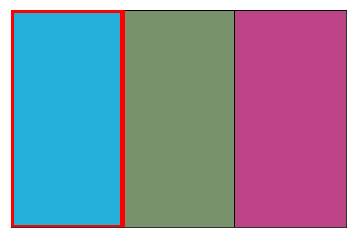

8440) Game: 0767-f Round: 9
not blue


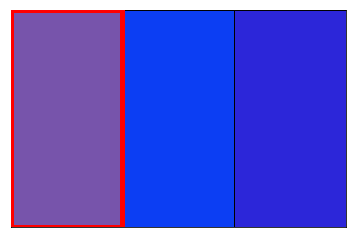

8441) Game: 0767-f Round: 10
royal blue


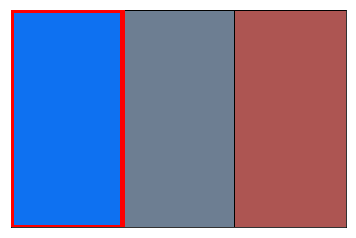

8442) Game: 0767-f Round: 11
olive drab


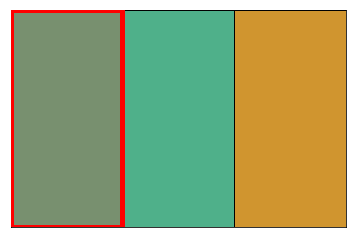

8443) Game: 0767-f Round: 12
greenish yellow


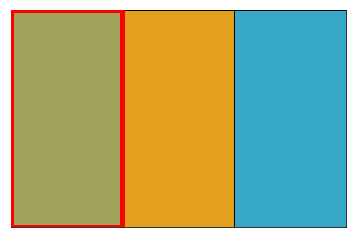

8444) Game: 0767-f Round: 13
pink


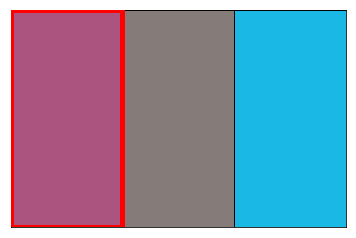

8445) Game: 0767-f Round: 14
yellow


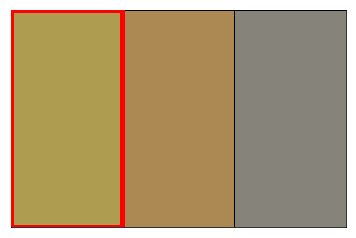

8446) Game: 0767-f Round: 15
blue


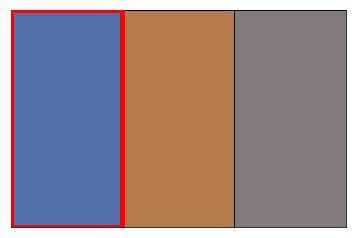

8447) Game: 0767-f Round: 16
gray


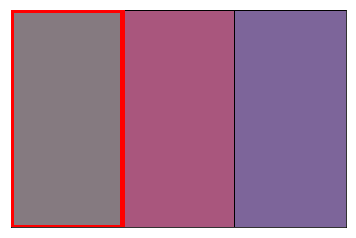

8448) Game: 0767-f Round: 17
light blue


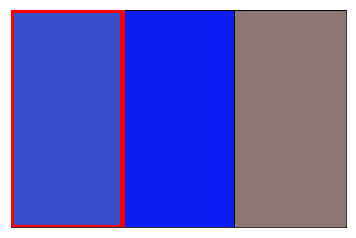

8449) Game: 0767-f Round: 18
green


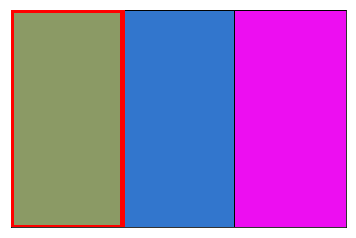

8450) Game: 0767-f Round: 19
blue


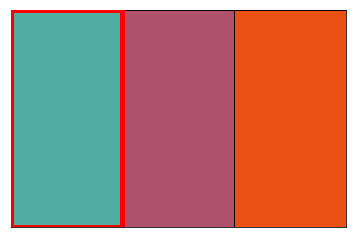

8451) Game: 0767-f Round: 20
gray


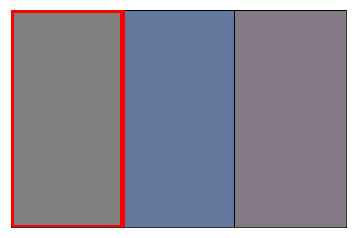

8452) Game: 0767-f Round: 21
bluish green


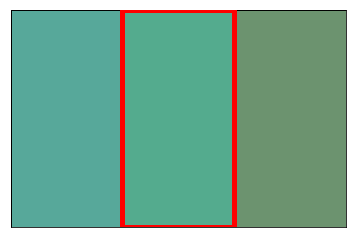

8453) Game: 0767-f Round: 22
gray


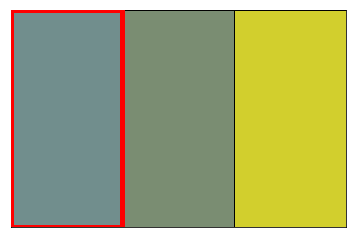

8454) Game: 0767-f Round: 23
pink


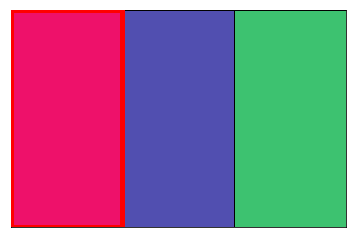

8455) Game: 0767-f Round: 24
green


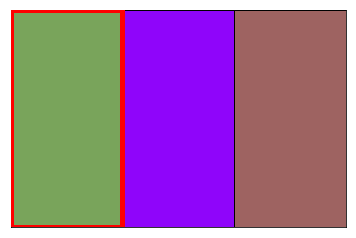

8456) Game: 0767-f Round: 25
gray


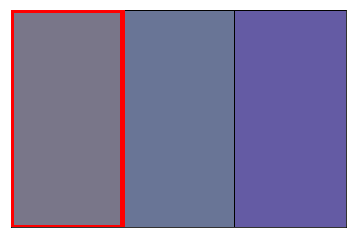

8457) Game: 0767-f Round: 26
bluish gray


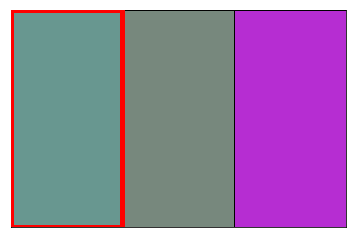

8458) Game: 0767-f Round: 27
blue


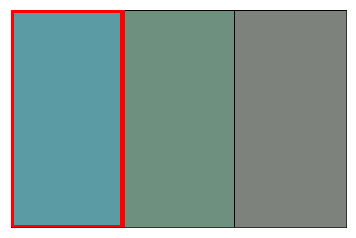

8459) Game: 0767-f Round: 28
blue


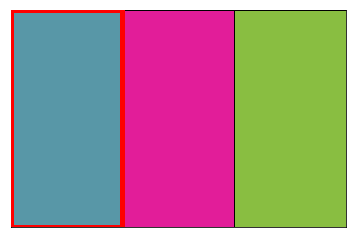

8460) Game: 0767-f Round: 29
darker green


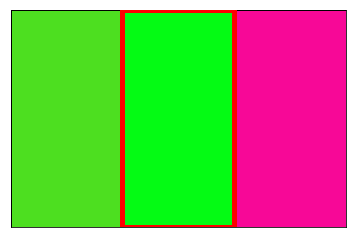

8461) Game: 0767-f Round: 30
gray


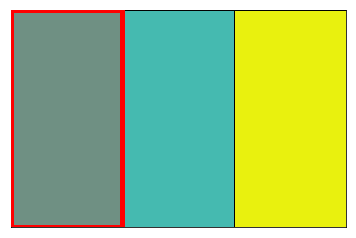

8462) Game: 0767-f Round: 31
purple gray


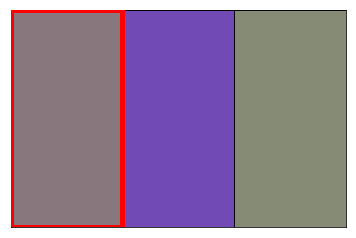

8463) Game: 0767-f Round: 32
bright green


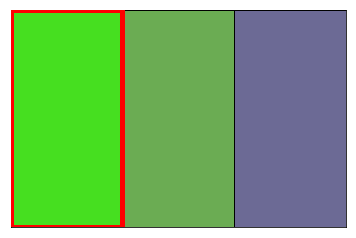

8464) Game: 0767-f Round: 33
yellow


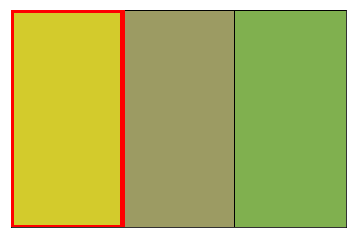

8465) Game: 0767-f Round: 34
red


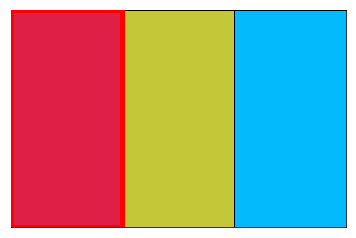

8466) Game: 0767-f Round: 35
briht green


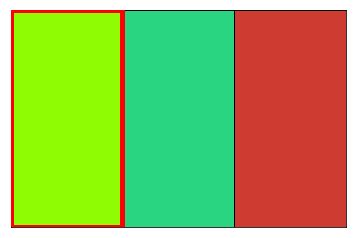

8467) Game: 0767-f Round: 36
yellow


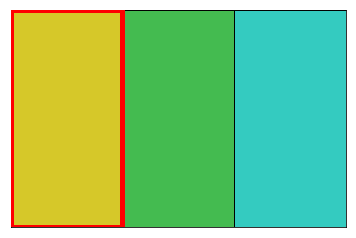

8468) Game: 0767-f Round: 37
green


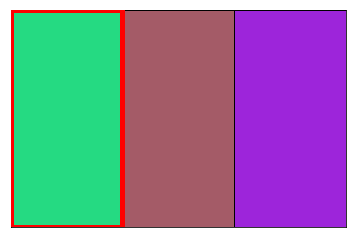

8469) Game: 0767-f Round: 38
gray


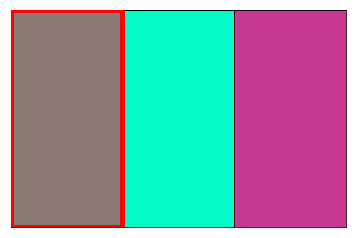

8470) Game: 0767-f Round: 39
purple


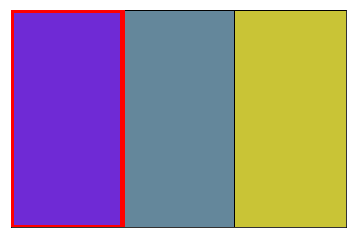

8471) Game: 0767-f Round: 40
pink


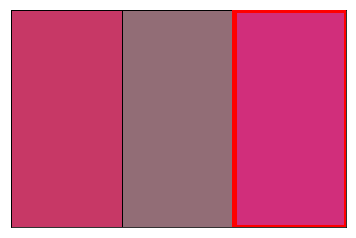

8472) Game: 0767-f Round: 41
green gray


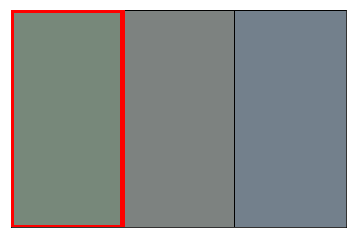

8473) Game: 0767-f Round: 42
bright green


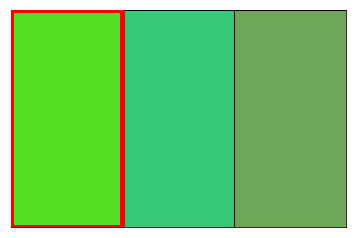

8474) Game: 0767-f Round: 43
blue


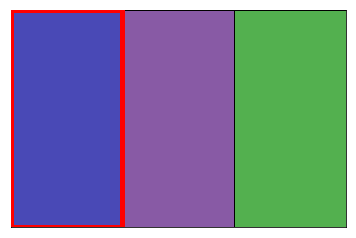

8475) Game: 0767-f Round: 44
orange


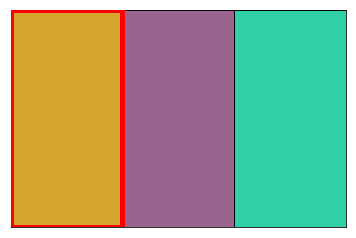

8476) Game: 0767-f Round: 45
gray


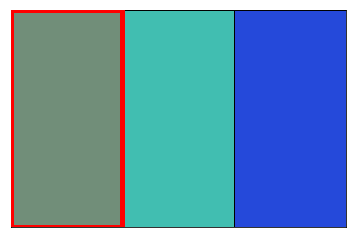

8477) Game: 0767-f Round: 46
yellow green


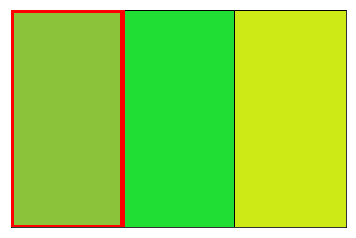

8478) Game: 0767-f Round: 47
blue


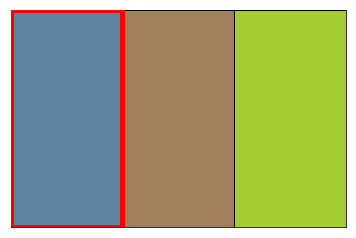

8479) Game: 0767-f Round: 48
gray


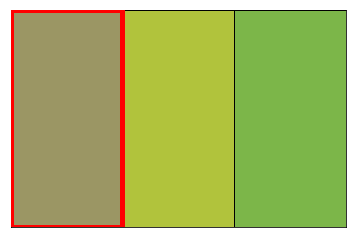

8480) Game: 0767-f Round: 49
yellow gray


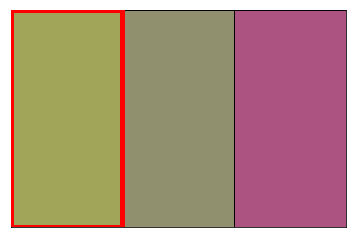

8481) Game: 0767-f Round: 50
blue gray


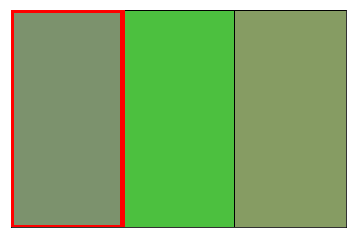

In [229]:
dev_data.display_game_for_gameid("0767-f")

8681) Game: 4860-7 Round: 1
It's the color of a shark.


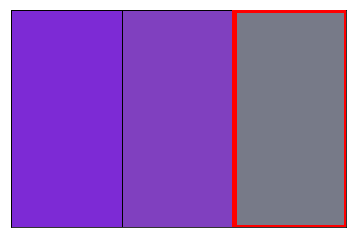

8682) Game: 4860-7 Round: 2
It's the color of an orange.


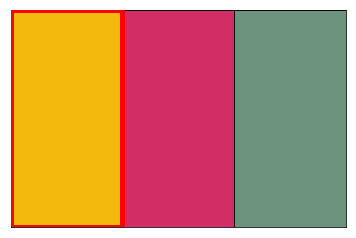

8683) Game: 4860-7 Round: 3
It's the color of a valentine.


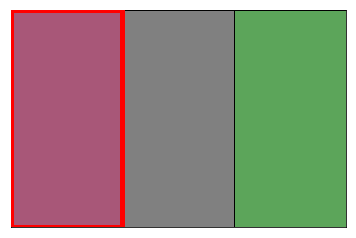

8684) Game: 4860-7 Round: 4
Color of the sky.


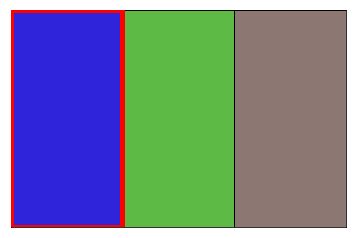

8685) Game: 4860-7 Round: 5
Color of army camo


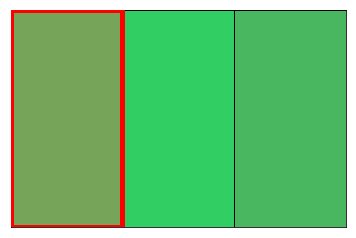

8686) Game: 4860-7 Round: 6
Color of concrete


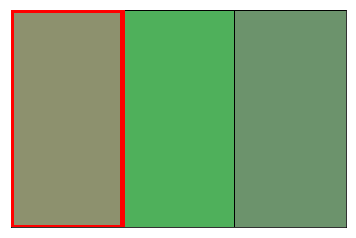

8687) Game: 4860-7 Round: 7
Closest to color of grass


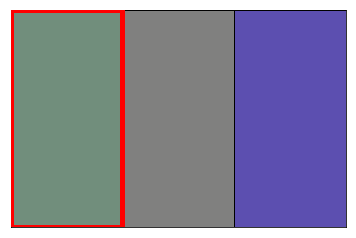

8688) Game: 4860-7 Round: 8
Not the color of a grape or concrete ~ It's hard to tell with this box around it, but I think lighter


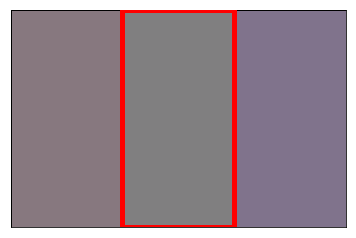

8689) Game: 4860-7 Round: 9
Color of grass


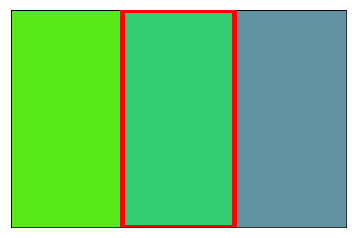

8690) Game: 4860-7 Round: 10
Color of a grape


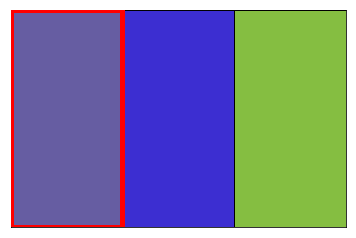

8691) Game: 4860-7 Round: 11
Not the color of the sky or an orange


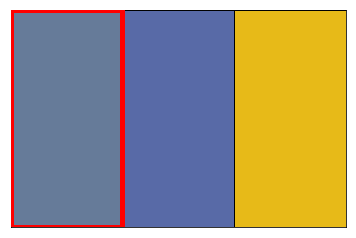

8692) Game: 4860-7 Round: 12
Color of a grape


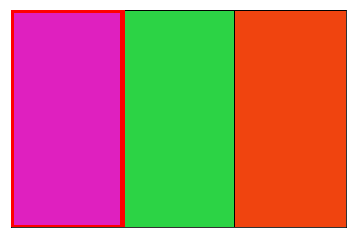

8693) Game: 4860-7 Round: 13
Color of a grape


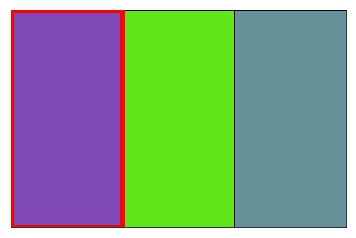

8694) Game: 4860-7 Round: 14
The darkest color


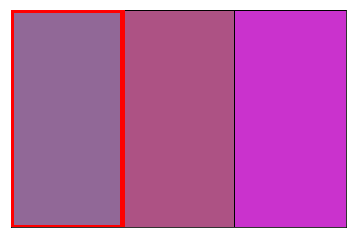

8695) Game: 4860-7 Round: 15
Color grass


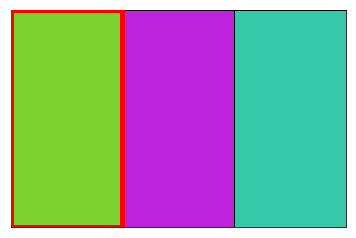

8696) Game: 4860-7 Round: 16
Color of a grape


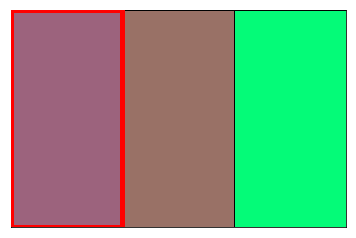

8697) Game: 4860-7 Round: 17
Grape


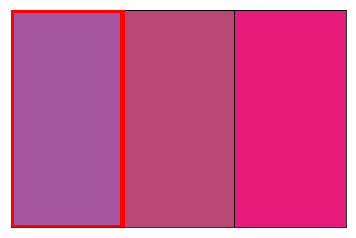

8698) Game: 4860-7 Round: 18
Color of the sky, darker color


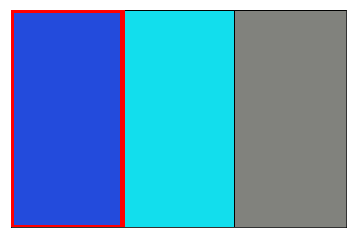

8699) Game: 4860-7 Round: 19
Lightest color


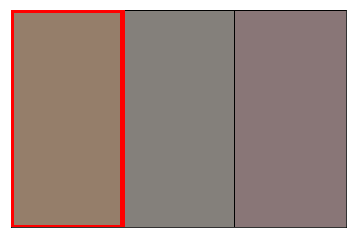

8700) Game: 4860-7 Round: 20
Grape


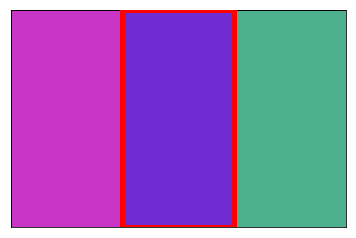

8701) Game: 4860-7 Round: 21
Color of a tank


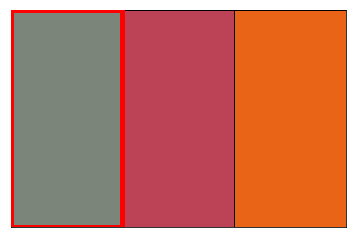

8702) Game: 4860-7 Round: 22
Darkest color


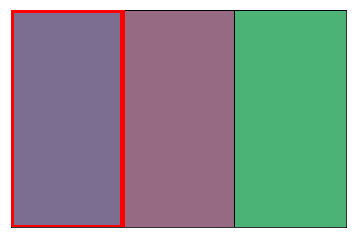

8703) Game: 4860-7 Round: 23
Darkest color, but not gray


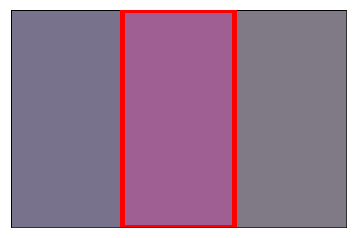

8704) Game: 4860-7 Round: 24
Lightest color


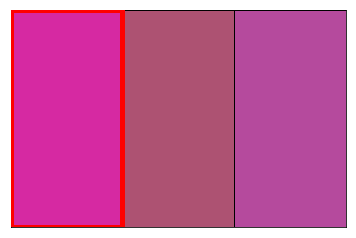

8705) Game: 4860-7 Round: 25
Color of the sky


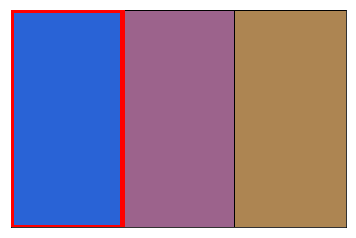

8706) Game: 4860-7 Round: 26
Color of a rose


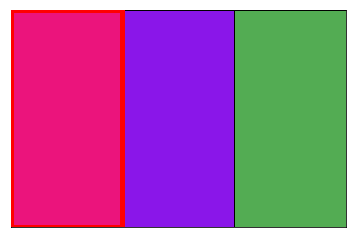

8707) Game: 4860-7 Round: 27
Color of grass


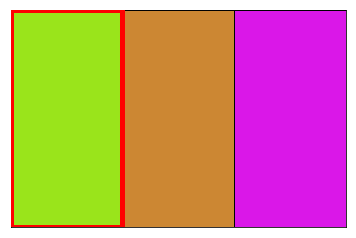

8708) Game: 4860-7 Round: 28
Lightest color


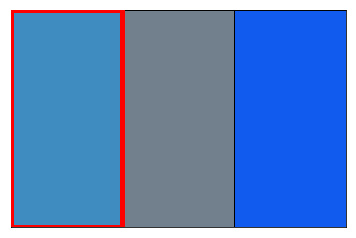

8709) Game: 4860-7 Round: 29
Color of grass


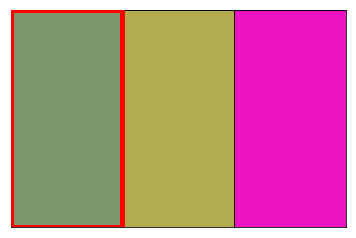

8710) Game: 4860-7 Round: 30
Color of the sun


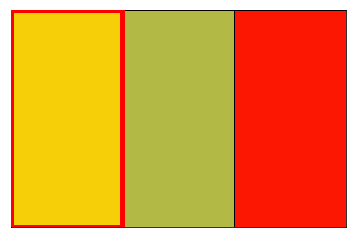

8711) Game: 4860-7 Round: 31
Darker shade of two similar colors


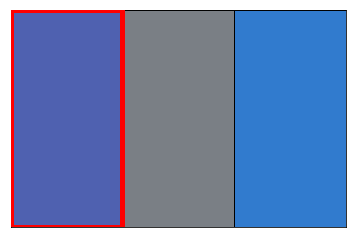

8712) Game: 4860-7 Round: 32
Lighter shade of two similar colors


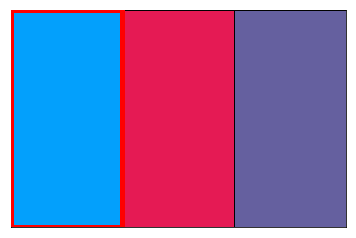

8713) Game: 4860-7 Round: 33
Darker shade of two similar colors


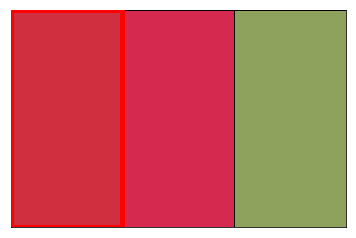

8714) Game: 4860-7 Round: 34
Darkest shade


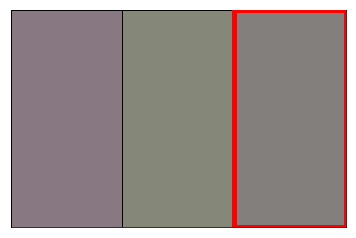

8715) Game: 4860-7 Round: 35
Color of mud


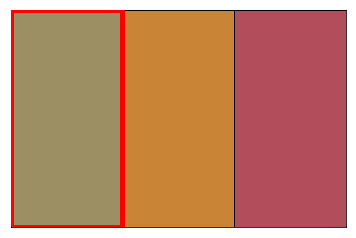

8716) Game: 4860-7 Round: 36
Lightest shade


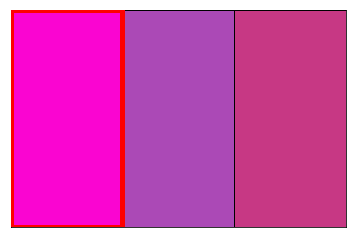

8717) Game: 4860-7 Round: 37
LIghtest shade


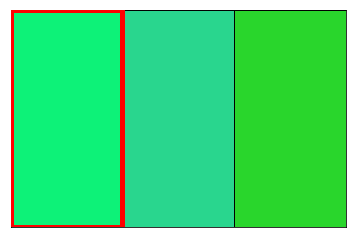

8718) Game: 4860-7 Round: 38
Middle shade


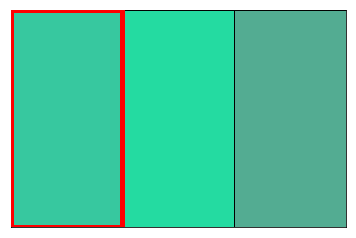

8719) Game: 4860-7 Round: 39
Color of the sk ~ y


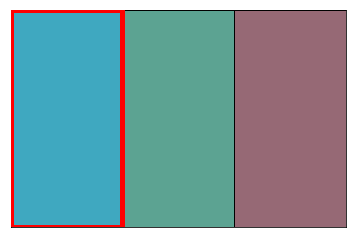

8720) Game: 4860-7 Round: 40
Color of grass


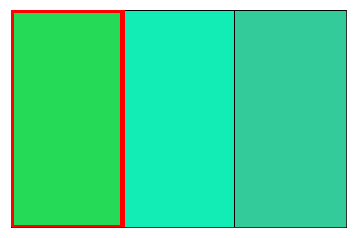

8721) Game: 4860-7 Round: 41
Lighter of two similar shades


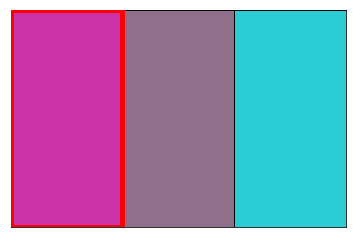

8722) Game: 4860-7 Round: 42
Darker of two similar shades


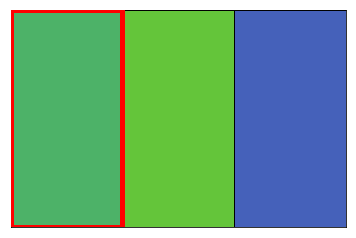

8723) Game: 4860-7 Round: 43
Medium shade


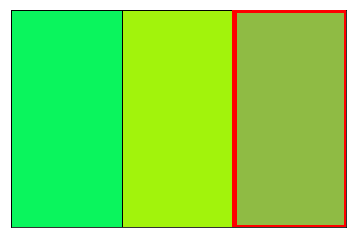

8724) Game: 4860-7 Round: 44
Color of cement


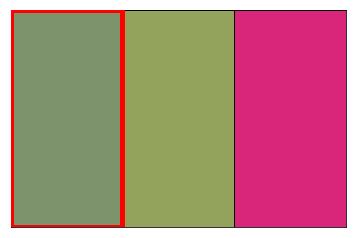

8725) Game: 4860-7 Round: 45
Least similar of the three colors


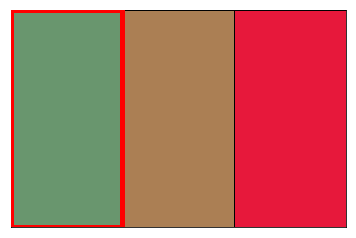

8726) Game: 4860-7 Round: 46
Color of an orange


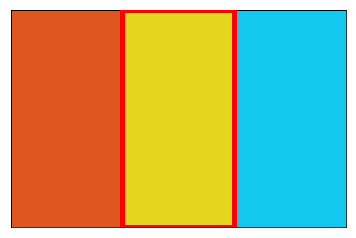

8727) Game: 4860-7 Round: 47
Color of grass


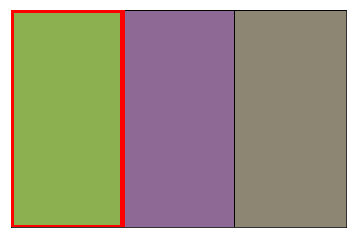

8728) Game: 4860-7 Round: 48
Darkest color


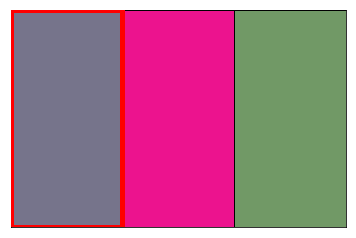

8729) Game: 4860-7 Round: 49
Color of a rose


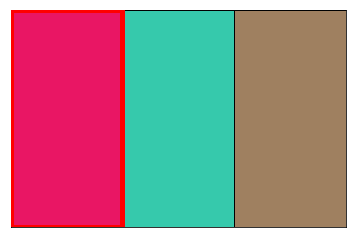

8730) Game: 4860-7 Round: 50
Darker of two similar colors


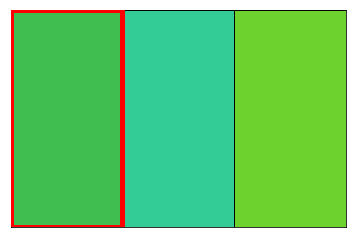

In [233]:
dev_data.display_game_for_gameid("4860-7")

9672) Game: 2639-b Round: 1
bright purple


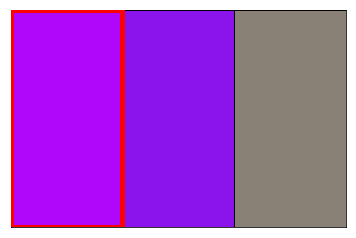

9673) Game: 2639-b Round: 2
darker green


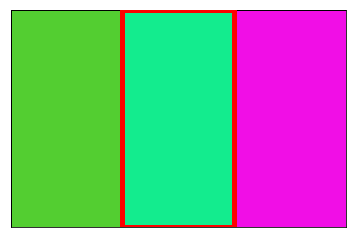

9674) Game: 2639-b Round: 3
pink


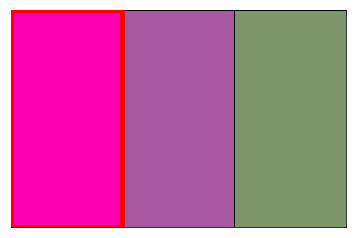

9675) Game: 2639-b Round: 4
the darker shade of green


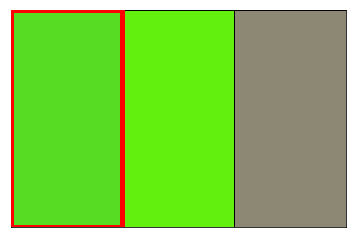

9676) Game: 2639-b Round: 5
darkest green


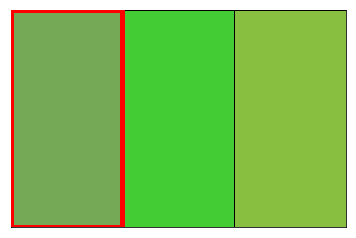

9677) Game: 2639-b Round: 6
purple


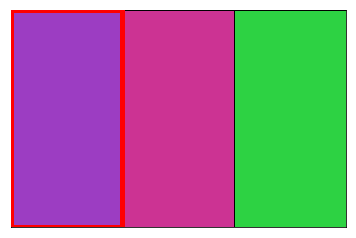

9678) Game: 2639-b Round: 7
light blue


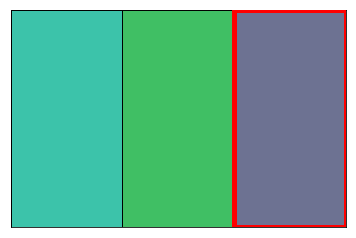

9679) Game: 2639-b Round: 8
yellow


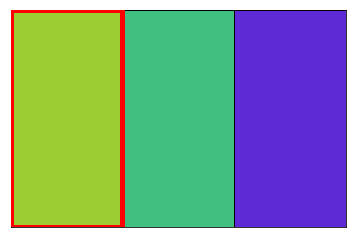

9680) Game: 2639-b Round: 9
pink


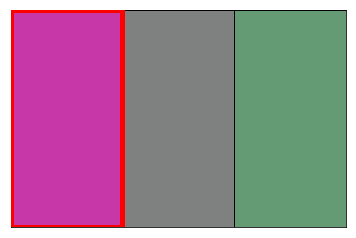

9681) Game: 2639-b Round: 10
purple


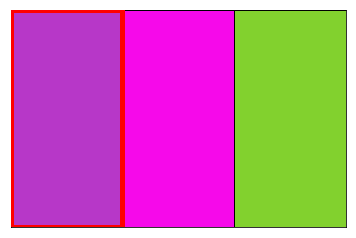

9682) Game: 2639-b Round: 11
green


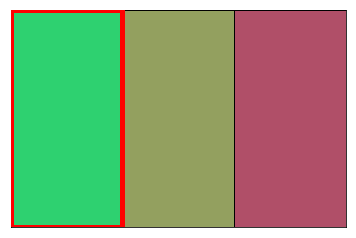

9683) Game: 2639-b Round: 12
purple


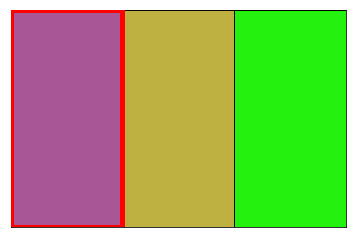

9684) Game: 2639-b Round: 13
grey blue


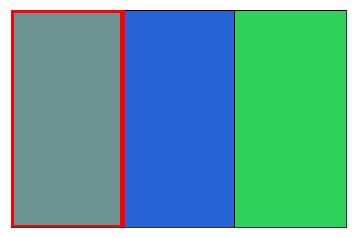

9685) Game: 2639-b Round: 14
grey blue


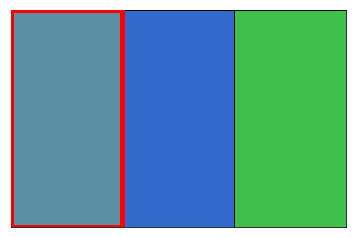

9686) Game: 2639-b Round: 15
darkest grey


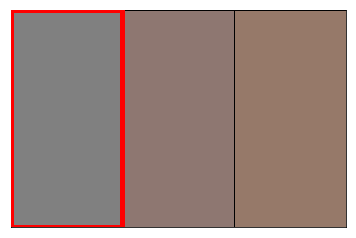

9687) Game: 2639-b Round: 16
purple


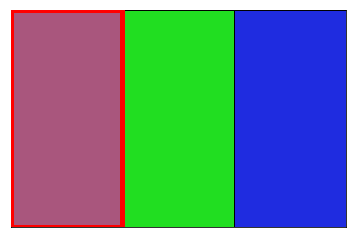

9688) Game: 2639-b Round: 17
grey green


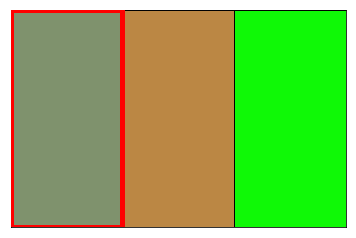

9689) Game: 2639-b Round: 18
darker grey purple


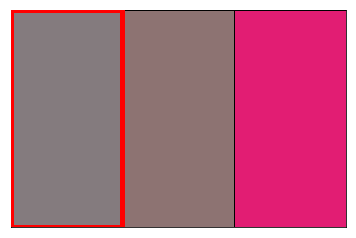

9690) Game: 2639-b Round: 19
purple hint of grey


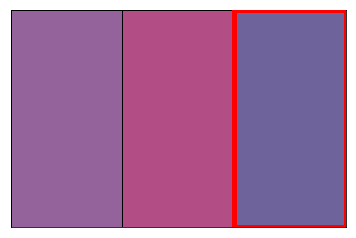

9691) Game: 2639-b Round: 20
blue


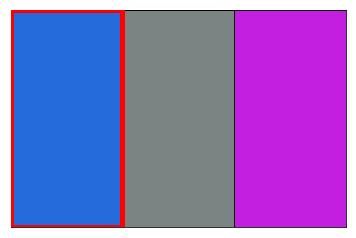

9692) Game: 2639-b Round: 21
truest purple


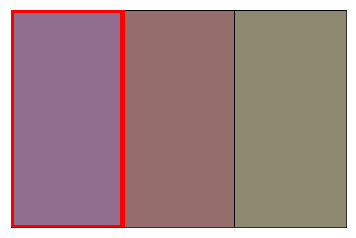

9693) Game: 2639-b Round: 22
purple


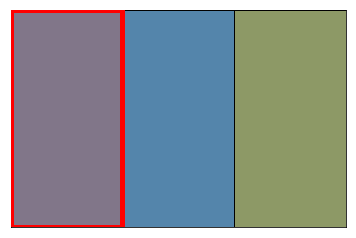

9694) Game: 2639-b Round: 23
purple not the lightest not the darkest


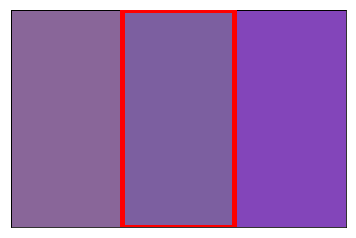

9695) Game: 2639-b Round: 24
grey


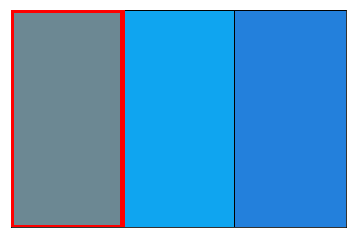

9696) Game: 2639-b Round: 25
green


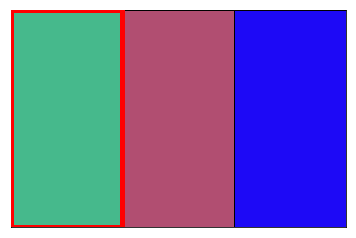

9697) Game: 2639-b Round: 26
pink


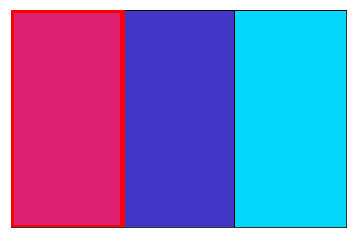

9698) Game: 2639-b Round: 27
grey blue


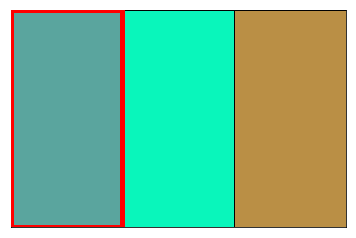

9699) Game: 2639-b Round: 28
most green


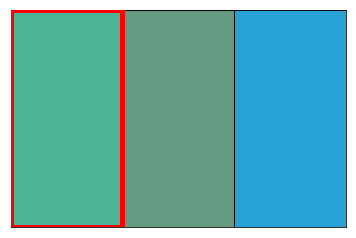

9700) Game: 2639-b Round: 29
blue/purple


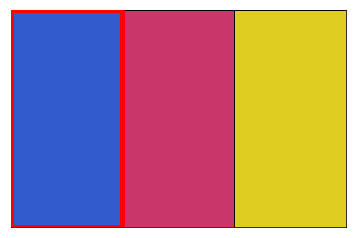

9701) Game: 2639-b Round: 30
purple most blue


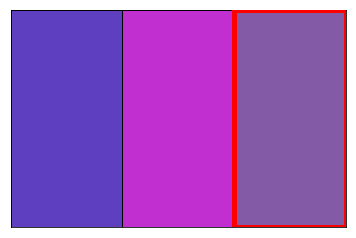

9702) Game: 2639-b Round: 31
blue


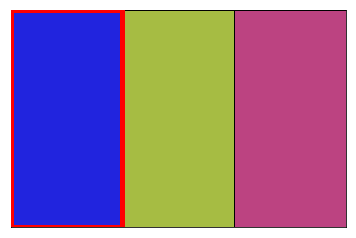

9703) Game: 2639-b Round: 32
darkest grey


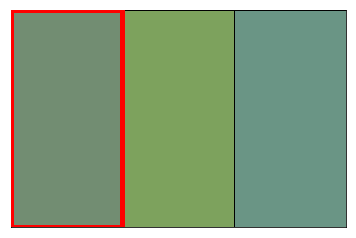

9704) Game: 2639-b Round: 33
darkest purple


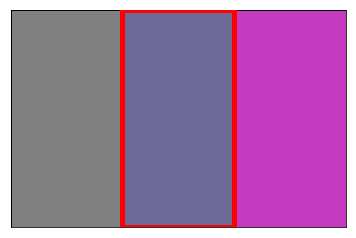

9705) Game: 2639-b Round: 34
grey blue


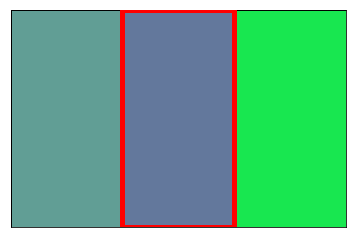

9706) Game: 2639-b Round: 35
grayish orange


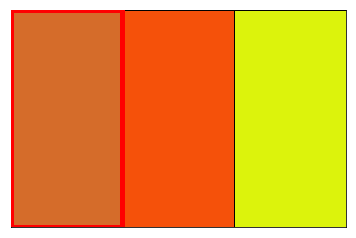

9707) Game: 2639-b Round: 36
purple darkest


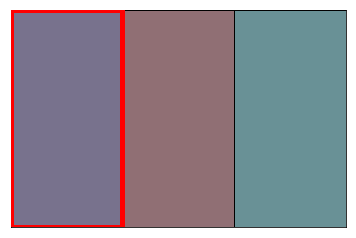

9708) Game: 2639-b Round: 37
green closer to blue ~ blue ~ lightest blue


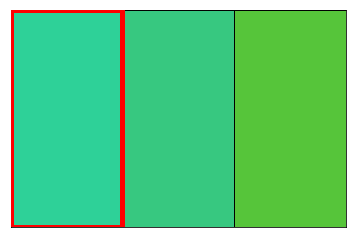

9709) Game: 2639-b Round: 38
green


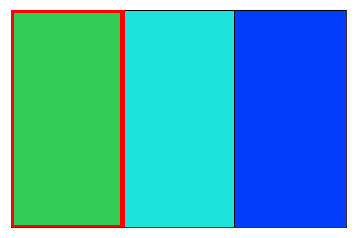

9710) Game: 2639-b Round: 39
red


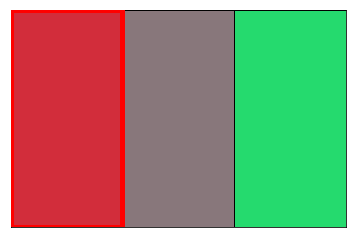

9711) Game: 2639-b Round: 40
darkest green


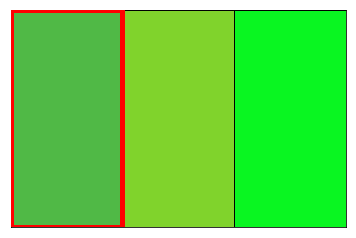

9712) Game: 2639-b Round: 41
red


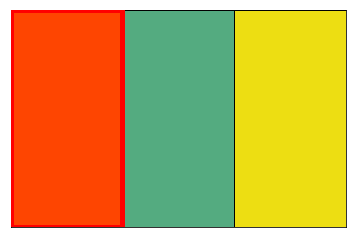

9713) Game: 2639-b Round: 42
light blue


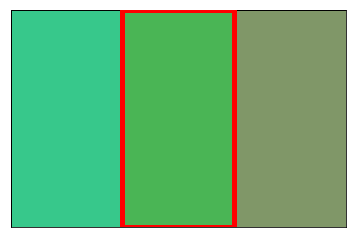

9714) Game: 2639-b Round: 43
grayish purple


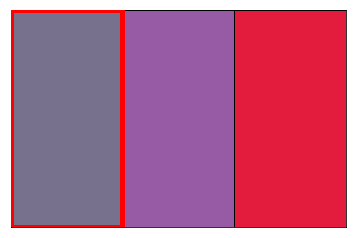

9715) Game: 2639-b Round: 44
light green


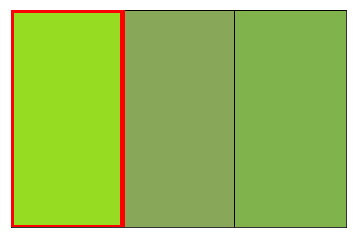

9716) Game: 2639-b Round: 45
tan


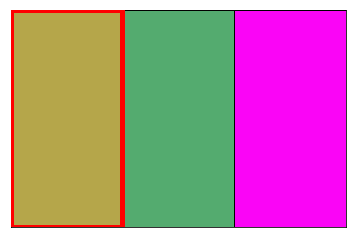

9717) Game: 2639-b Round: 46
brightest pink


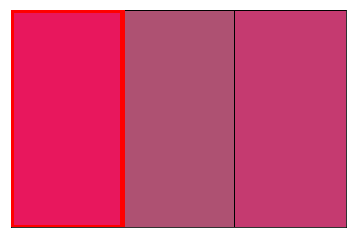

9718) Game: 2639-b Round: 47
most blue


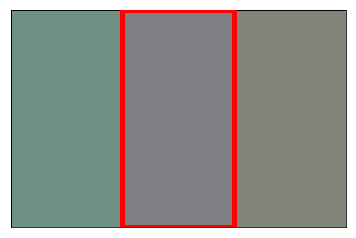

9719) Game: 2639-b Round: 48
darkest purple closer to grey


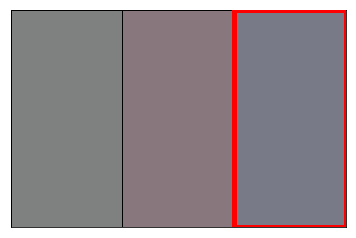

9720) Game: 2639-b Round: 49
greenish grey


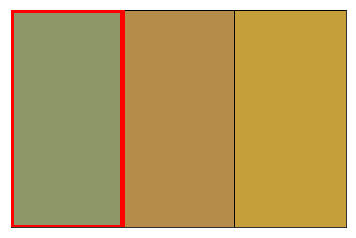

9721) Game: 2639-b Round: 50
purple closest to grey


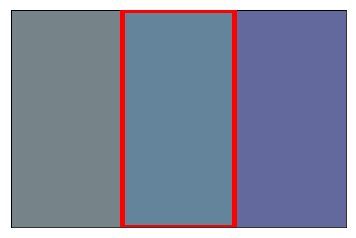

In [236]:
dev_data.display_game_for_gameid("2639-b")

2882) Game: 3332-5 Round: 1
Hello ~ Yellow


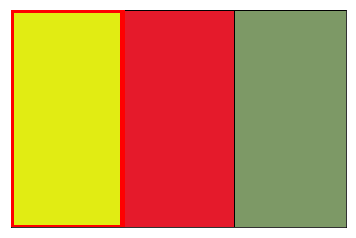

2883) Game: 3332-5 Round: 2
Darkest one


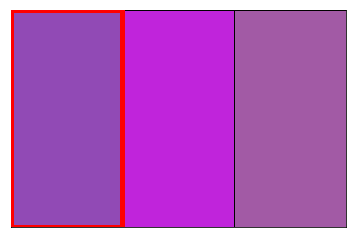

2884) Game: 3332-5 Round: 3
Blue


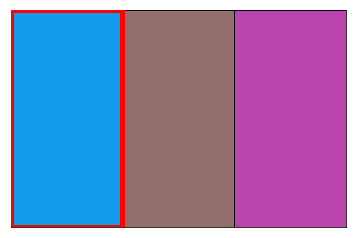

2885) Game: 3332-5 Round: 4
Green


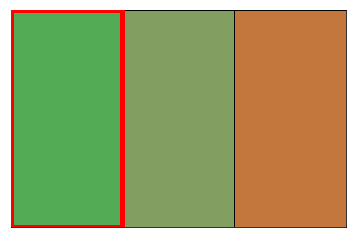

2886) Game: 3332-5 Round: 5
Pink


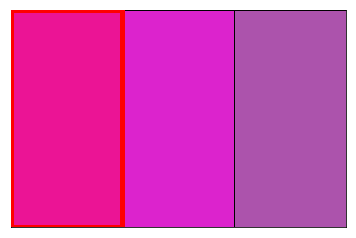

2887) Game: 3332-5 Round: 6
Red


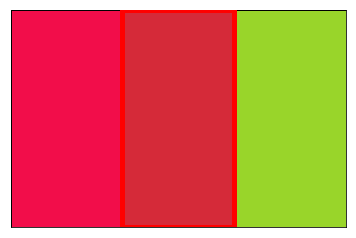

2888) Game: 3332-5 Round: 7
Darkest one


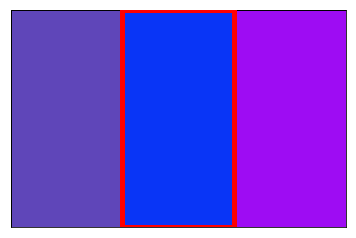

2889) Game: 3332-5 Round: 8
Green


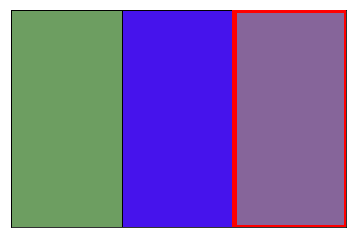

2890) Game: 3332-5 Round: 9
Olive


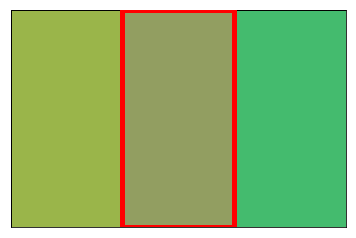

2891) Game: 3332-5 Round: 10
Green medium pale


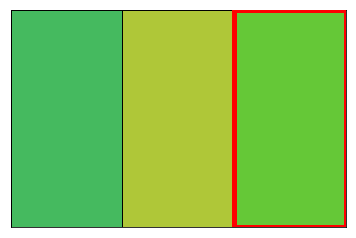

2892) Game: 3332-5 Round: 11
Grey dark


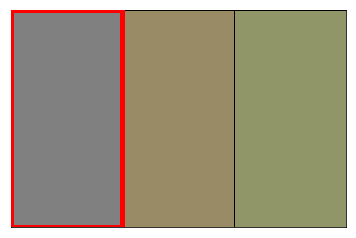

2893) Game: 3332-5 Round: 12
Green


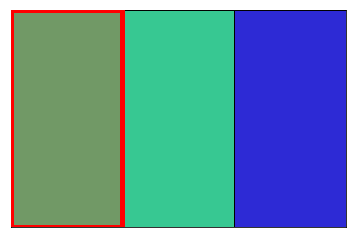

2894) Game: 3332-5 Round: 13
Blue


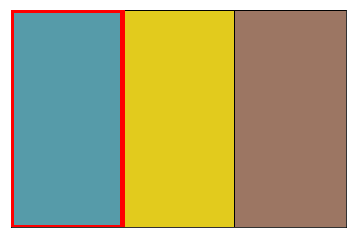

2895) Game: 3332-5 Round: 14
Red


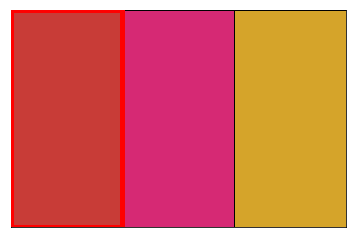

2896) Game: 3332-5 Round: 15
Green


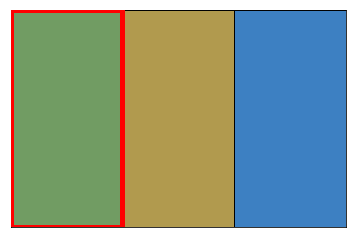

2897) Game: 3332-5 Round: 16
Yellow


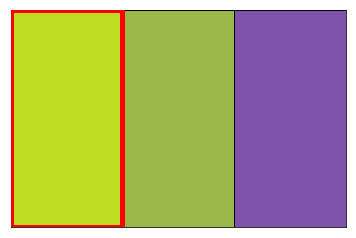

2898) Game: 3332-5 Round: 17
Pink


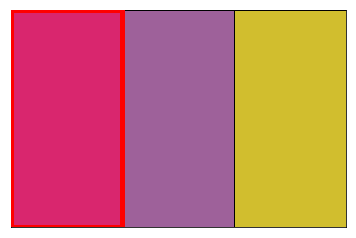

2899) Game: 3332-5 Round: 18
Blue pale


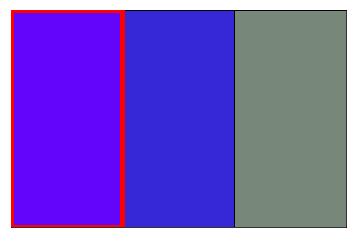

2900) Game: 3332-5 Round: 19
Brown


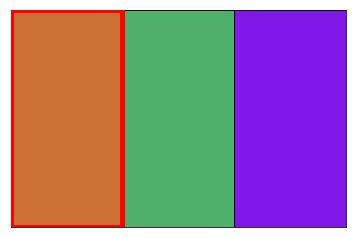

2901) Game: 3332-5 Round: 20
Grey


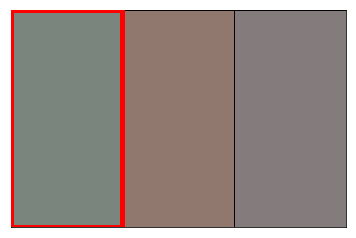

2902) Game: 3332-5 Round: 21
Blue


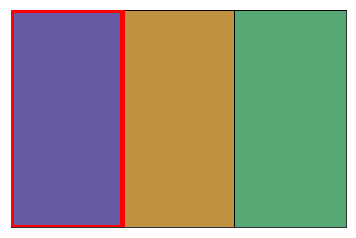

2903) Game: 3332-5 Round: 22
Pink


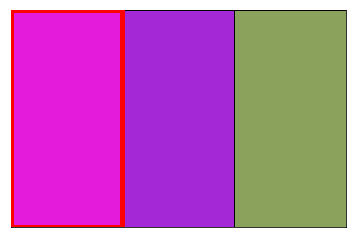

2904) Game: 3332-5 Round: 23
Green pale the lightest one


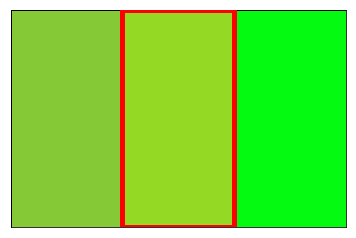

2905) Game: 3332-5 Round: 24
The darkest one more grey


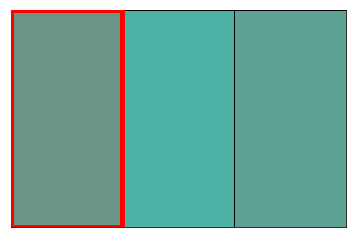

2906) Game: 3332-5 Round: 25
Tan


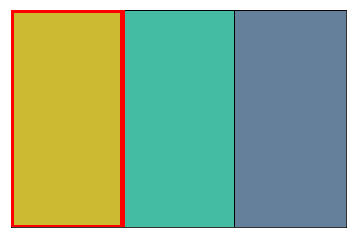

2907) Game: 3332-5 Round: 26
Bluish purple


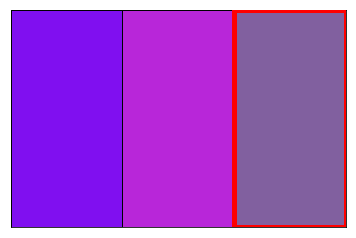

2908) Game: 3332-5 Round: 27
Grey


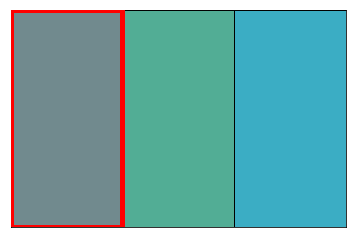

2909) Game: 3332-5 Round: 28
Blue


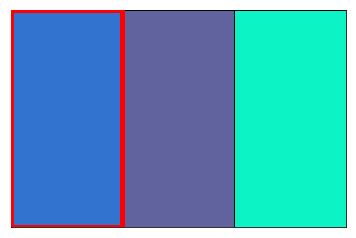

2910) Game: 3332-5 Round: 29
Olive green


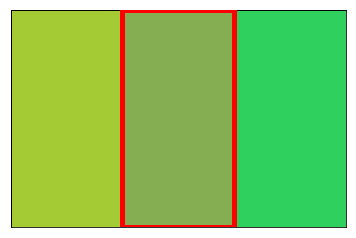

2911) Game: 3332-5 Round: 30
Green


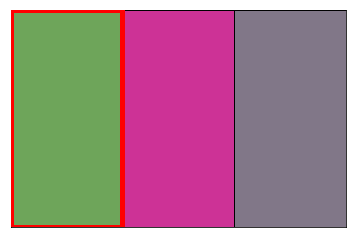

2912) Game: 3332-5 Round: 31
Brown


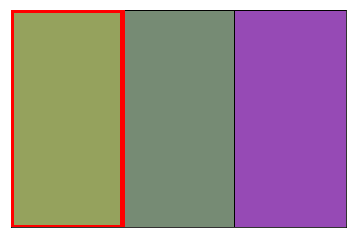

2913) Game: 3332-5 Round: 32
Green olive


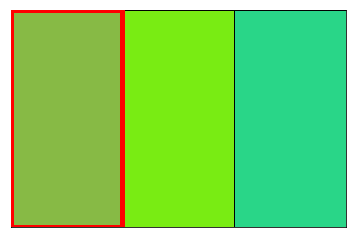

2914) Game: 3332-5 Round: 33
Green army dark


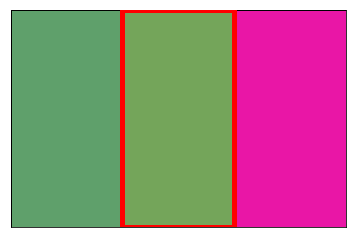

2915) Game: 3332-5 Round: 34
Purple dark


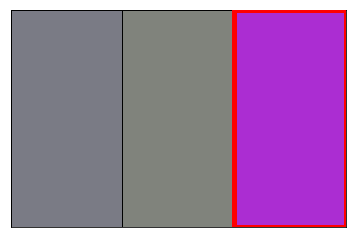

2916) Game: 3332-5 Round: 35
Blue


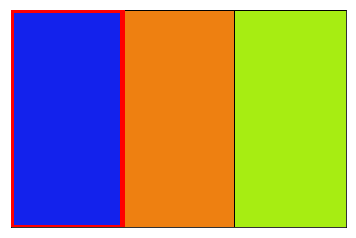

2917) Game: 3332-5 Round: 36
Purple


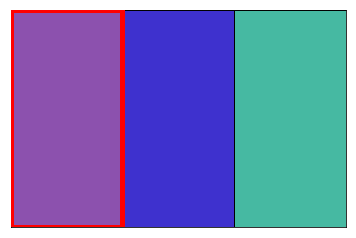

2918) Game: 3332-5 Round: 37
Grey


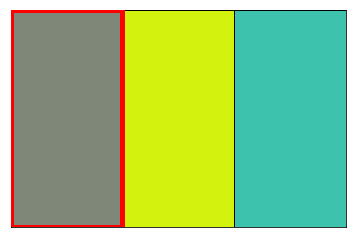

2919) Game: 3332-5 Round: 38
Purple middle color not bright not dark


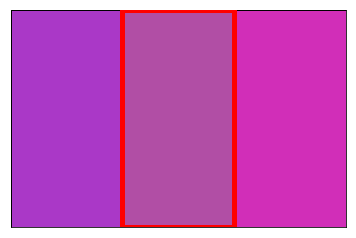

2920) Game: 3332-5 Round: 39
Pink


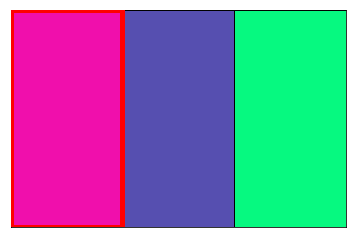

2921) Game: 3332-5 Round: 40
Yellow


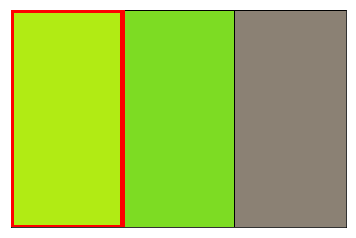

2922) Game: 3332-5 Round: 41
Grey


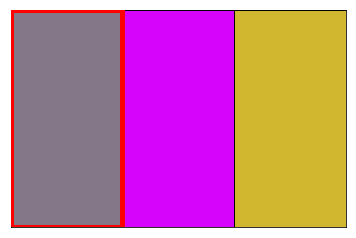

2923) Game: 3332-5 Round: 42
Brown


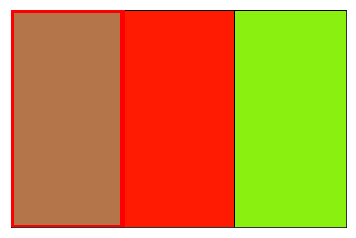

2924) Game: 3332-5 Round: 43
Purple


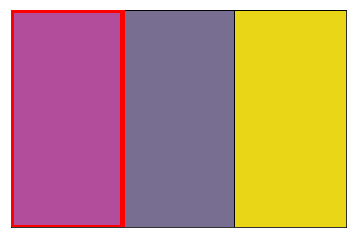

2925) Game: 3332-5 Round: 44
Blue grey


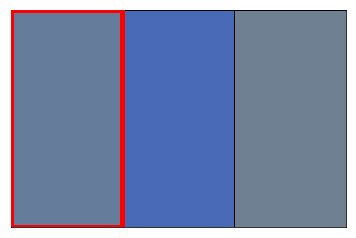

2926) Game: 3332-5 Round: 45
purple


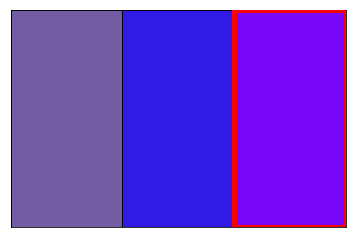

2927) Game: 3332-5 Round: 46
Purple


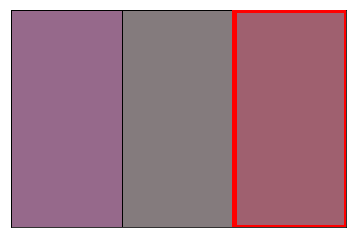

2928) Game: 3332-5 Round: 47
Teal


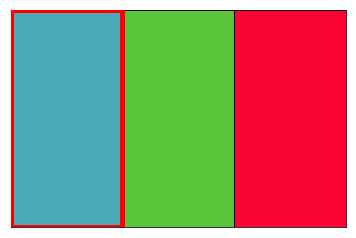

2929) Game: 3332-5 Round: 48
Brown


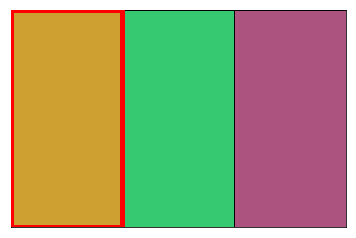

2930) Game: 3332-5 Round: 49
Grey


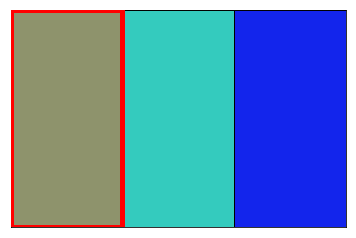

2931) Game: 3332-5 Round: 50
Purple


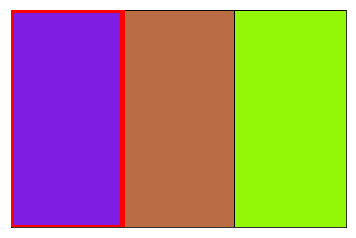

In [237]:
dev_data.display_game_for_gameid("3332-5")

In [243]:
dev_data[5196].condition

'split'

987) Game: 5727-1 Round: 1
grass


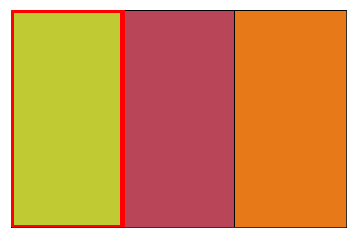

988) Game: 5727-1 Round: 2
grass


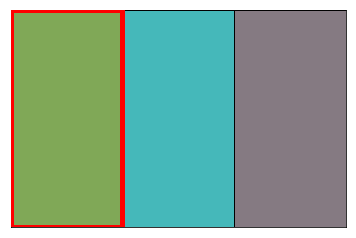

989) Game: 5727-1 Round: 3
sky


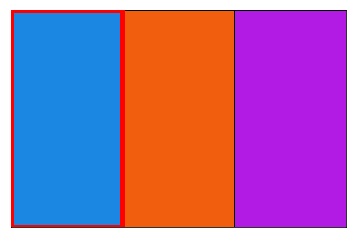

990) Game: 5727-1 Round: 4
battleship


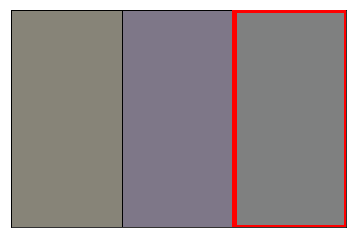

991) Game: 5727-1 Round: 5
ocean


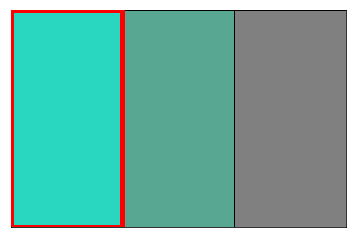

992) Game: 5727-1 Round: 6
grape


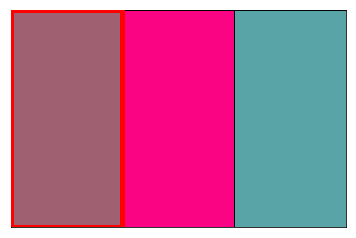

993) Game: 5727-1 Round: 7
battleship


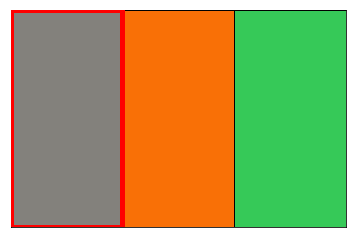

994) Game: 5727-1 Round: 8
grass


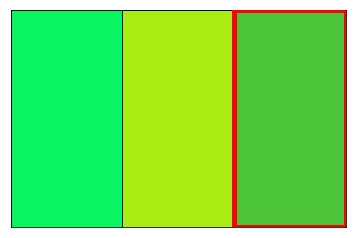

995) Game: 5727-1 Round: 9
grape


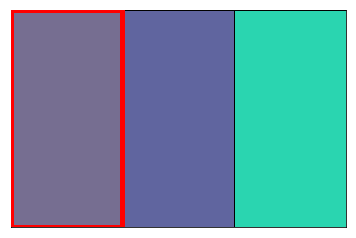

996) Game: 5727-1 Round: 10
plumbgrante


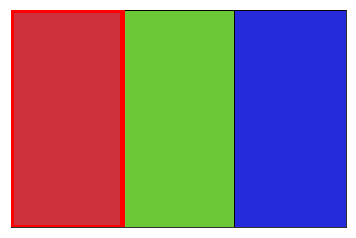

997) Game: 5727-1 Round: 11
battleship


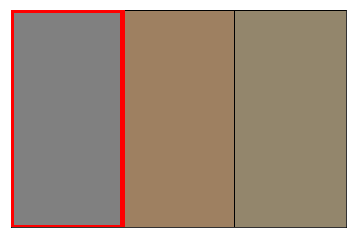

998) Game: 5727-1 Round: 12
squash


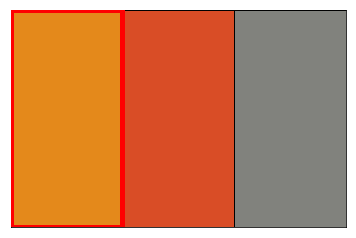

999) Game: 5727-1 Round: 13
grape


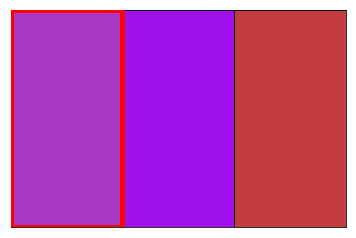

1000) Game: 5727-1 Round: 14
sky


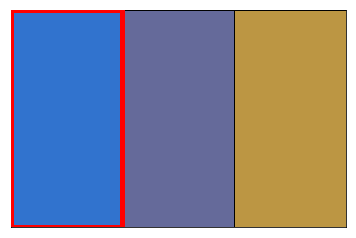

1001) Game: 5727-1 Round: 15
sea


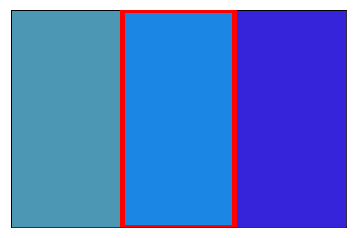

1002) Game: 5727-1 Round: 16
olive


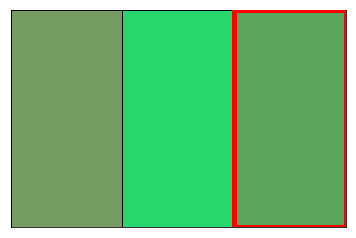

1003) Game: 5727-1 Round: 17
sky


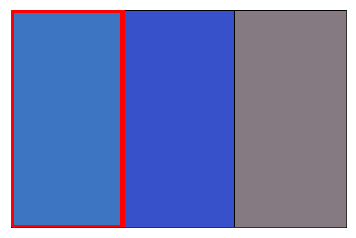

1004) Game: 5727-1 Round: 18
grape


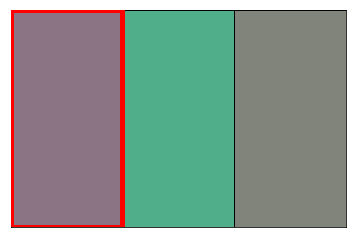

1005) Game: 5727-1 Round: 19
grass


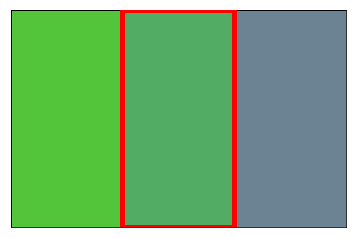

1006) Game: 5727-1 Round: 20
pea


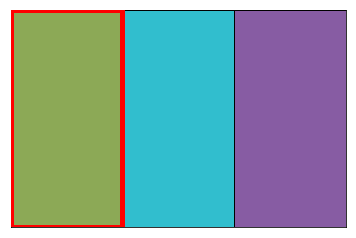

1007) Game: 5727-1 Round: 21
banana


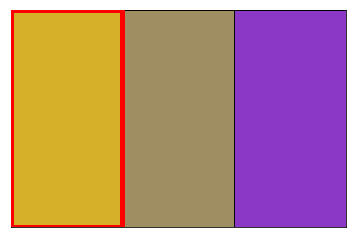

1008) Game: 5727-1 Round: 22
canvas


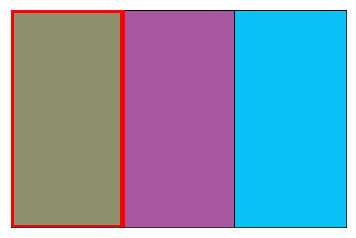

1009) Game: 5727-1 Round: 23
grass


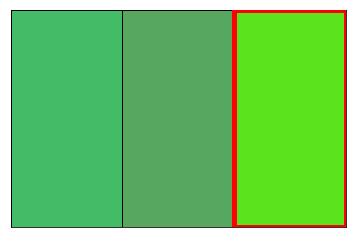

1010) Game: 5727-1 Round: 24
sky


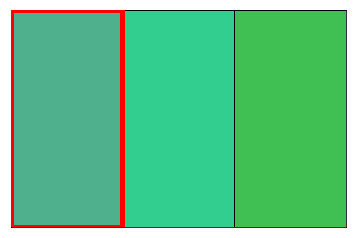

1011) Game: 5727-1 Round: 25
squash


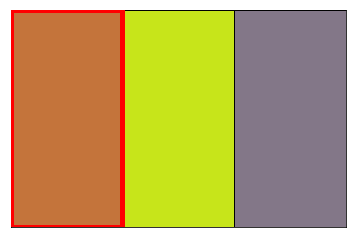

1012) Game: 5727-1 Round: 26
grape


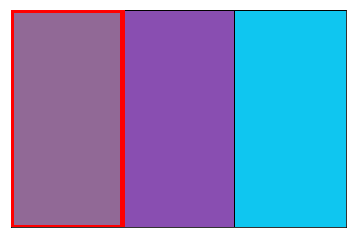

1013) Game: 5727-1 Round: 27
crater lake


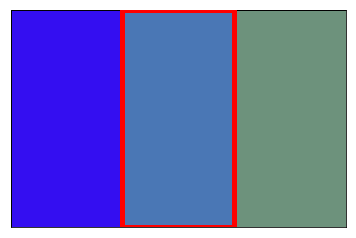

1014) Game: 5727-1 Round: 28
lavander


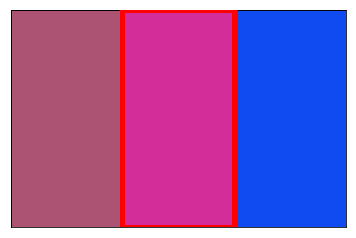

1015) Game: 5727-1 Round: 29
grape


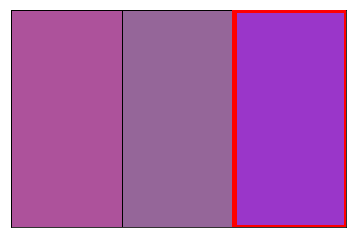

1016) Game: 5727-1 Round: 30
battleship


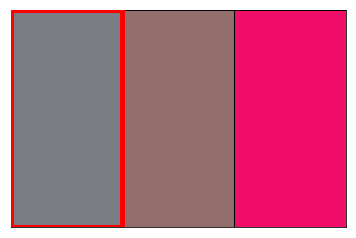

1017) Game: 5727-1 Round: 31
canvas


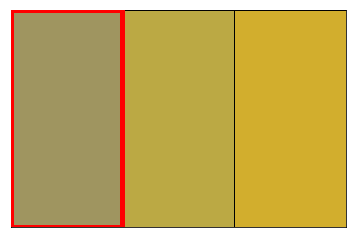

1018) Game: 5727-1 Round: 32
shy


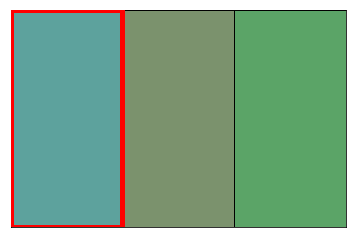

1019) Game: 5727-1 Round: 33
grape


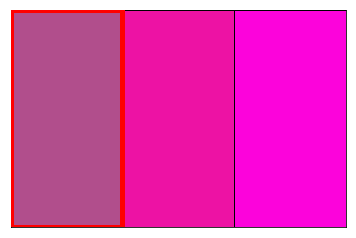

1020) Game: 5727-1 Round: 34
girl color


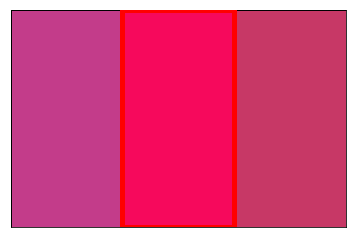

1021) Game: 5727-1 Round: 35
battleship


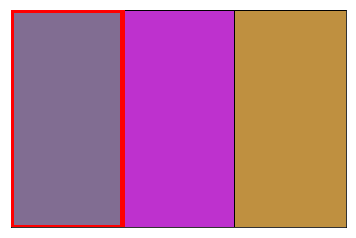

1022) Game: 5727-1 Round: 36
grape


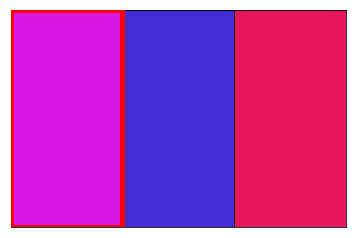

1023) Game: 5727-1 Round: 37
grape


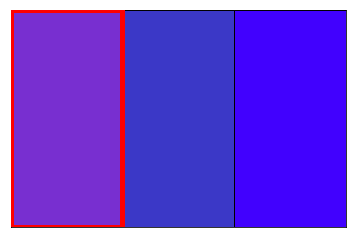

1024) Game: 5727-1 Round: 38
battleship


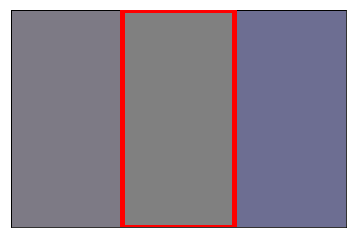

1025) Game: 5727-1 Round: 39
battleship


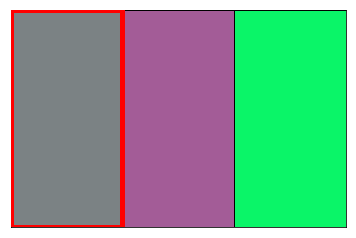

1026) Game: 5727-1 Round: 40
sea


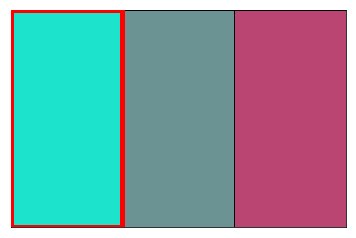

1027) Game: 5727-1 Round: 41
canvas


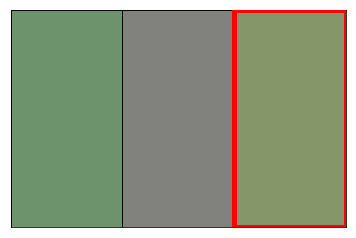

1028) Game: 5727-1 Round: 42
battleship


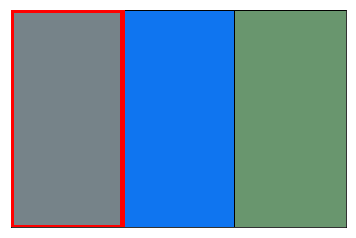

1029) Game: 5727-1 Round: 43
not a lemon but a


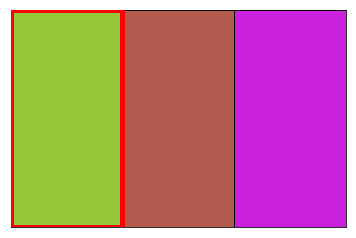

1030) Game: 5727-1 Round: 44
grass


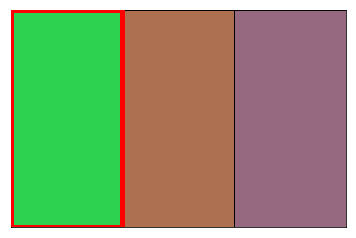

1031) Game: 5727-1 Round: 45
battleship


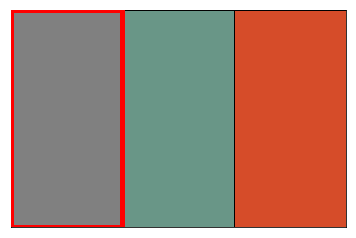

1032) Game: 5727-1 Round: 46
grape


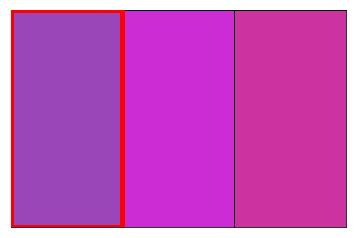

1033) Game: 5727-1 Round: 47
baby girl color


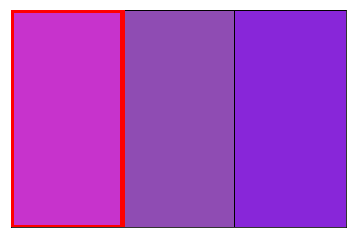

1034) Game: 5727-1 Round: 48
sea


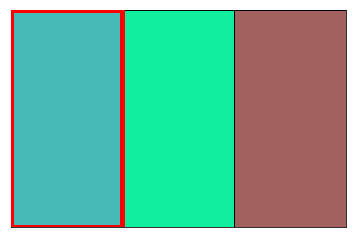

1035) Game: 5727-1 Round: 49
sea


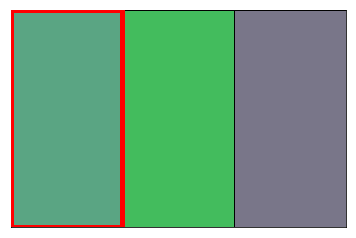

1036) Game: 5727-1 Round: 50
grass


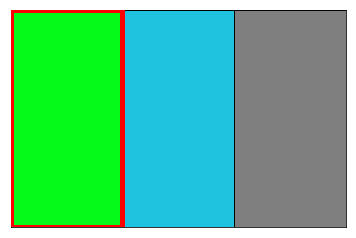

In [240]:
dev_data.display_game_for_gameid("5727-1")


5148) Game: 9922-e Round: 1
the purple shade


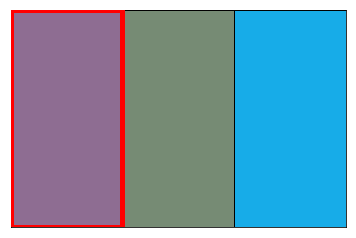

5149) Game: 9922-e Round: 2
the brighter violet


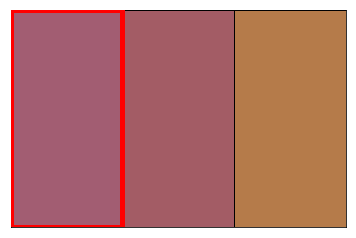

5150) Game: 9922-e Round: 3
the grayish one


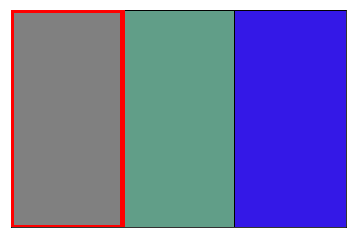

5151) Game: 9922-e Round: 4
the dull pink


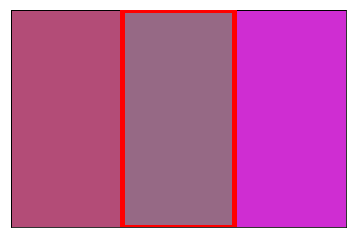

5152) Game: 9922-e Round: 5
the sage colored box


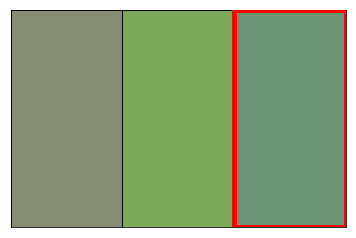

5153) Game: 9922-e Round: 6
bright green


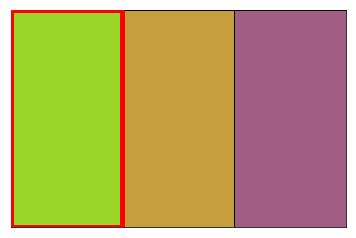

5154) Game: 9922-e Round: 7
gray


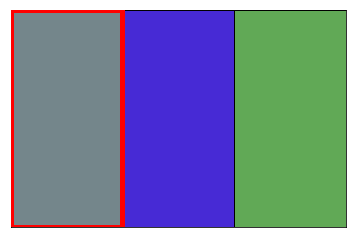

5155) Game: 9922-e Round: 8
medium green ~ yes


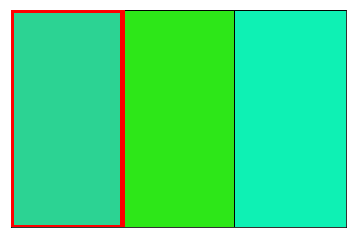

5156) Game: 9922-e Round: 9
brighter violet


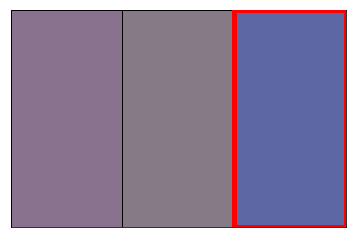

5157) Game: 9922-e Round: 10
bluish purple


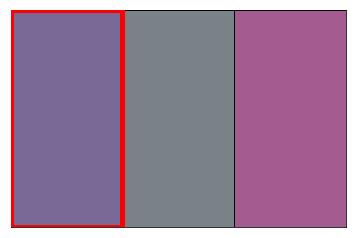

5158) Game: 9922-e Round: 11
brown


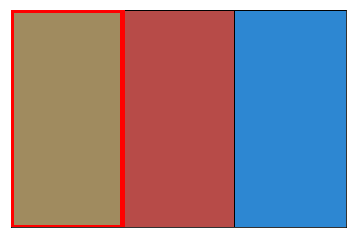

5159) Game: 9922-e Round: 12
pink


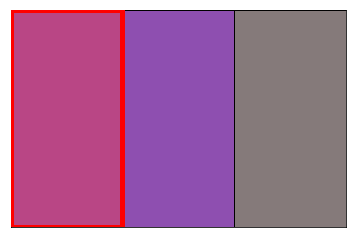

5160) Game: 9922-e Round: 13
bright green


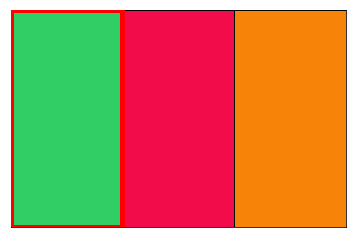

5161) Game: 9922-e Round: 14
blue


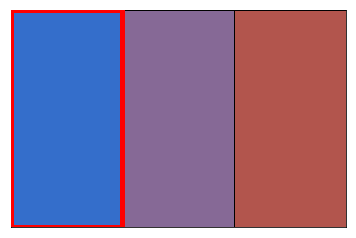

5162) Game: 9922-e Round: 15
bright green


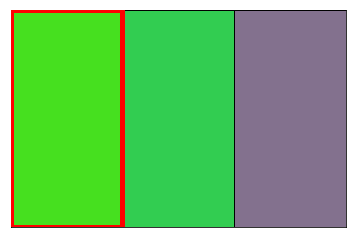

5163) Game: 9922-e Round: 16
blue


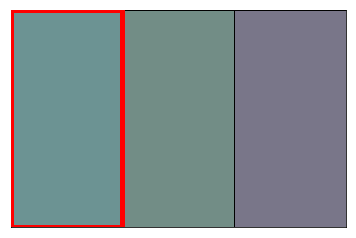

5164) Game: 9922-e Round: 17
pinkish orange ~ more like rose


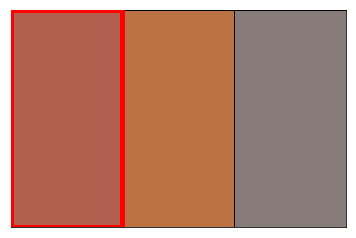

5165) Game: 9922-e Round: 18
green


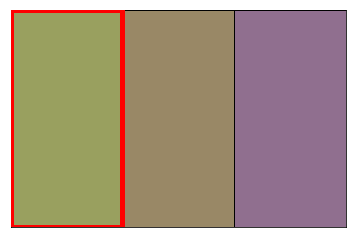

5166) Game: 9922-e Round: 19
blue


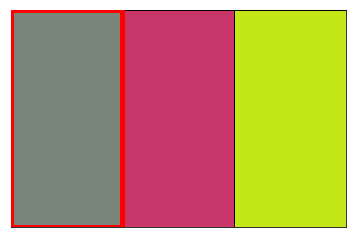

5167) Game: 9922-e Round: 20
purple ~ brighter one


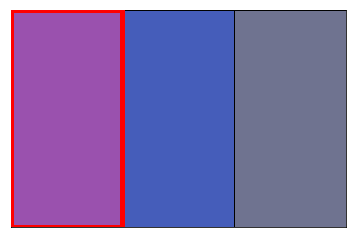

5168) Game: 9922-e Round: 21
grayish green


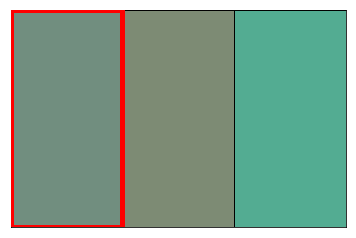

5169) Game: 9922-e Round: 22
kight green


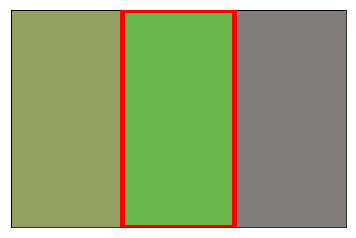

5170) Game: 9922-e Round: 23
dull blue


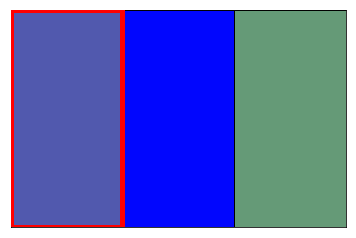

5171) Game: 9922-e Round: 24
green


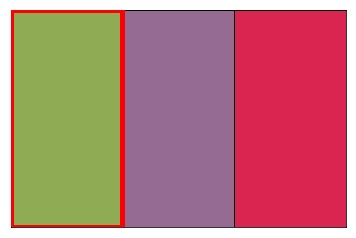

5172) Game: 9922-e Round: 25
purple


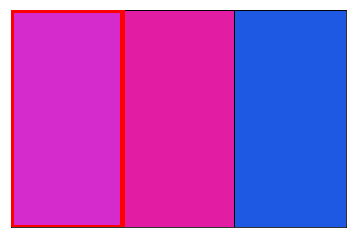

5173) Game: 9922-e Round: 26
blue, not sky blue ~ medium shade


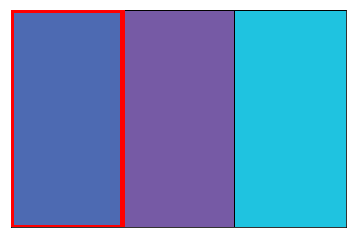

5174) Game: 9922-e Round: 27
gray


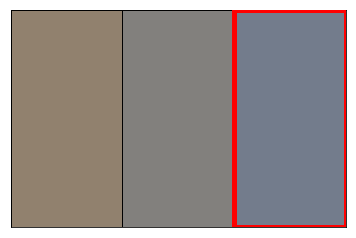

5175) Game: 9922-e Round: 28
darker blue


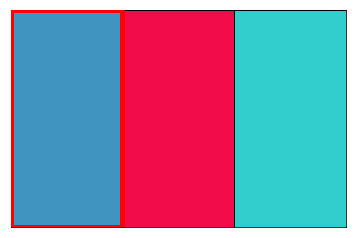

5176) Game: 9922-e Round: 29
violet


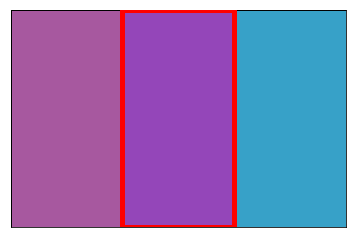

5177) Game: 9922-e Round: 30
yellow


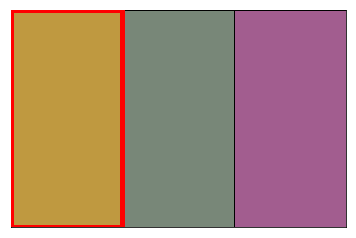

5178) Game: 9922-e Round: 31
bright purple


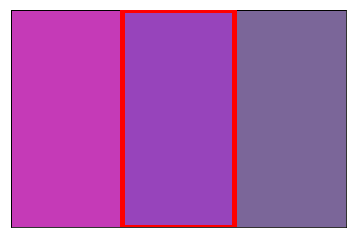

5179) Game: 9922-e Round: 32
blue green


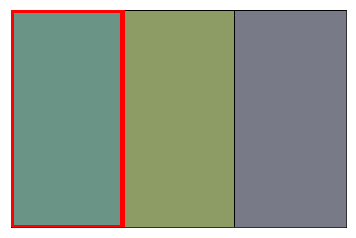

5180) Game: 9922-e Round: 33
bright blue


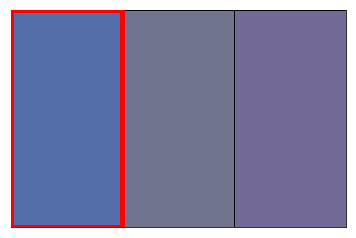

5181) Game: 9922-e Round: 34
dull purple ~ yes


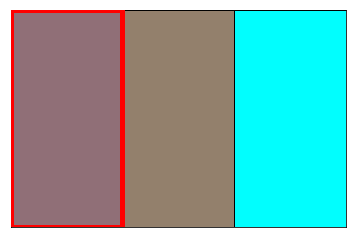

5182) Game: 9922-e Round: 35
yellow


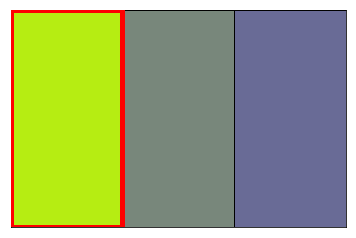

5183) Game: 9922-e Round: 36
not so bright green ~ yes, but not the neon type


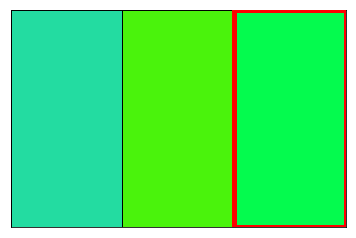

5184) Game: 9922-e Round: 37
blue


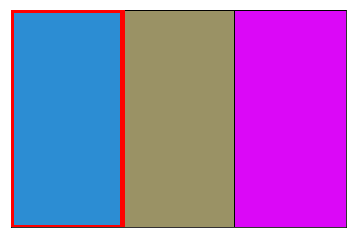

5185) Game: 9922-e Round: 38
lavender


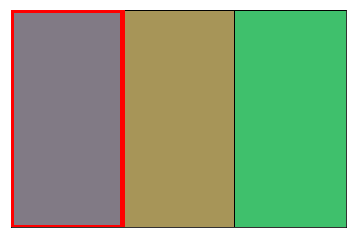

5186) Game: 9922-e Round: 39
greenish gray


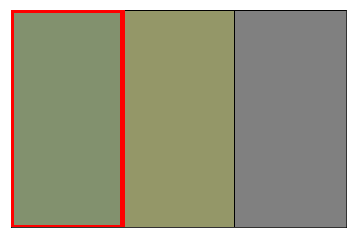

5187) Game: 9922-e Round: 40
yellow


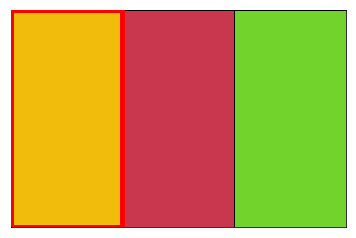

5188) Game: 9922-e Round: 41
violet ~ pink


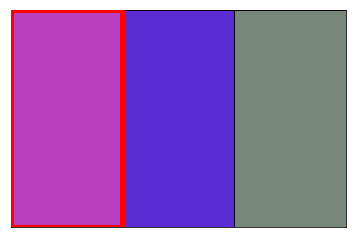

5189) Game: 9922-e Round: 42
green


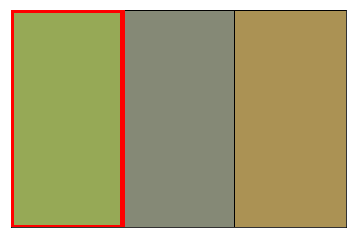

5190) Game: 9922-e Round: 43
gray


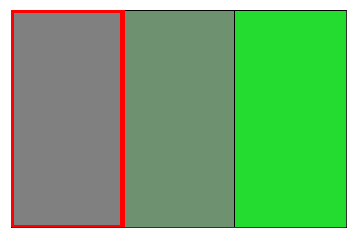

5191) Game: 9922-e Round: 44
lavender


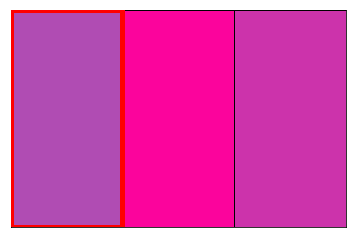

5192) Game: 9922-e Round: 45
duller green


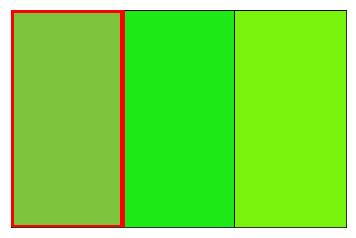

5193) Game: 9922-e Round: 46
mauve


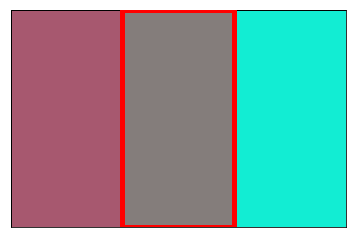

5194) Game: 9922-e Round: 47
darkest blue


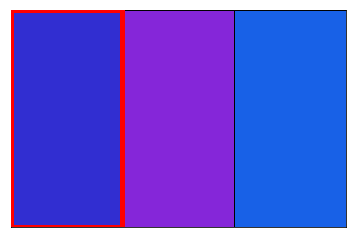

5195) Game: 9922-e Round: 48
darker blue ~ bright blue


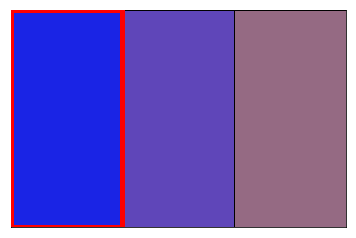

5196) Game: 9922-e Round: 49
sage


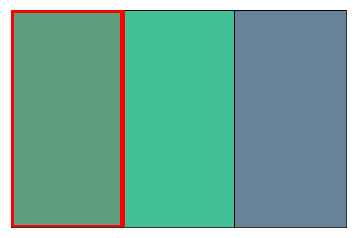

5197) Game: 9922-e Round: 50
yellow


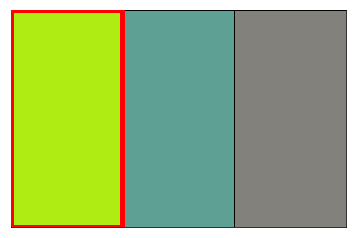

In [241]:
dev_data.display_game_for_gameid("9922-e")

In [ ]:
# create fake datasets from dev set:
# 1. get all of correct data
# 2. switch targets (be careful with split condition?)

In [245]:
dev_data_correct = dev_data.data[dev_data.data["numOutcome"] == 1]

In [247]:
dev_data_correct.head().T

,0,1,2,3,4
gameid,2641-2,2641-2,2641-2,2641-2,2641-2
clkTime,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12
roundNum,1,2,3,4,5
condition,split,split,far,split,far
clickStatus,target,target,target,target,target
clickColH,48,66,336,172,41
clickColS,13,26,24,60,71
clickColL,50,50,50,50,50
clickLocS,2,3,2,1,1
clickLocL,1,3,2,1,2


In [248]:
dev_data_correct.shape

(14165, 36)

In [290]:
dev_data_correct_entries = list(filter(lambda de: de.target_idx == de.click_idx, dev_data.entries))

In [291]:
len(dev_data_correct_entries)

14165

In [370]:
a = [1, 2, 3]

In [371]:
a[0], a[1] = a[1], a[0]

In [372]:
a

[2, 1, 3]

In [13]:
import copy
import random

One way to to generate these fake answers is to swap the target. This is ok except that it messes up the the whole "target is always on the left thing" that I have going on. I think it would be better to keep that the same so that it can work well with the models that we have so far (i.e. we don't have to change the model code that takes advantage of this). So instead, we're actually going to swap the colors and the click indexes.

In [373]:
%%time
fake_far_entries   = []
fake_close_entries = []
fake_split_entries = []
for de in dev_data_correct_entries:
    # if close or far, basically symmetric so add both (far fakes will be misleading, close fakes will be ambiguous)
    if de.condition == "far" or de.condition == "close":
        for i in range(1,3):
            de_cp = copy.deepcopy(de)
            de_cp.click_idx = i
            de_cp.colors[0], de_cp.colors[i] = de_cp.colors[i], de_cp.colors[0] # swap target and clicked colors
            #de_cp.target_idx = i # i = 1, 2
            de_cp.outcome = False
            if de.condition == "far":
                fake_far_entries.append(de_cp)
            else:
                fake_close_entries.append(de_cp)
    # we have to be a bit more careful, because the fake target really should
    # be the one that is closest to the target
    elif de.condition == "split":
        # get index to lookup in dataframe
        idx = de.index
        de_cp = copy.deepcopy(de)
        de_cp.outcome = False
        click_idx = 2 # assume the close one is the 2nd distractor
        if dev_data.data["targetD1Diff"][idx] < dev_data.data["targetD2Diff"][idx]:
            # D1 is the close distractor (and new target) - corresponds to color at index 1
            click_idx = 1
        de_cp.click_idx = click_idx
        de_cp.colors[0], de_cp.colors[click_idx] = de_cp.colors[click_idx], de_cp.colors[0]
        fake_split_entries.append(de_cp)

CPU times: user 5.85 s, sys: 1.91 s, total: 7.76 s
Wall time: 9.32 s


In [374]:
len(fake_far_entries)

10254

In [375]:
len(fake_close_entries)

8640

In [376]:
len(fake_split_entries)

4718

In [378]:
fake_split_entries[0].colors[0].rgb_norm

[hsl: [26, 34, 50], rgb [172, 122, 84], hsv [26, 50.74626865671642, 67.0],
 hsl: [48, 13, 50], rgb [145, 138, 111], hsv [48, 23.008849557522122, 56.5],
 hsl: [176, 67, 50], rgb [42, 214, 202], hsv [176, 80.23952095808383, 83.5]]

In [259]:
fake_split_entries[:4]

[gray, green, the brighter blue, the duller aqua]

In [263]:
dev_data_correct.condition.value_counts()

far      5127
split    4718
close    4320
Name: condition, dtype: int64

In [265]:
dev_data.data.groupby('gameid')['condition'].value_counts()

gameid  condition
0022-7  far          17
        split        17
        close        15
0069-8  far          17
        split        17
        close        16
0070-1  far          17
        split        17
        close        16
0106-1  far          17
        split        17
        close        16
0109-c  close        17
        far          17
        split        16
0137-f  close        17
        far          17
        split        16
0197-6  far          17
        split        17
        close        16
0217-e  far          17
        split        17
        close        16
0219-7  close        17
        split        17
        far          16
0239-7  close        17
        far          17
        split        16
                     ..
9709-7  close        17
        split        17
        far          16
9714-3  close        17
        far          17
        split        15
9719-9  far          17
        split        17
        close        16
9776-7  close        1

In [266]:
dev_data_correct.shape

(14165, 36)

In [269]:
14165/150

94

$$\frac{0}{5}x + \frac{1}{5}x + \frac{2}{5}x + \frac{3}{5}x + \frac{4}{5}x + \frac{5}{5}x = 3x = n$$
where $n$ is the number of samples, so $x$ is number of samples allocated for each fraction correct. $x = \frac{n}{3\cdot 50}$. We divide by 50 because there are 50 rounds per game. The smallest group we have is the correct close condition which has 4320 data points, so we take $n$ to be $3\cdot 4320 = 12960$ (multiplying by 3 because we have three conditions: close, far, and split.

More generally, with a minimum number of samples $n = 3\cdot4320$, and $f$ folds ($f = 5$ in the example above), the equation 
$\frac{\sum^f_{i=0}i}{50\cdot f}x = n$ gives the total number of samples allocated for of the $f$ folds from each group (real correct/synthesized incorrect).

$$50\cdot \frac{\sum^f_{i=0}i}{f}x = 50\frac{f\cdot(f+1)}{2\cdot f}x = 25
(f+1)x = n$$
So the of sampels for each round is $\frac{n}{25\cdot (f+1)}$, or in this particular case, $\frac{518.4}{f+1}$

In [408]:
num_games = lambda x: x*(x+1)/2/x

In [411]:
num_rounds_per_cond = num_games(10) * 50

In [413]:
int(4320/num_rounds_per_cond)

15

In [379]:
correct_entries = [[], [], []] # far, close, split
fake_entries = [fake_far_entries, fake_close_entries, fake_split_entries]

cond_map = {"far": 0, "close": 1, "split": 2}
for de in dev_data_correct_entries:
    correct_entries[cond_map[de.condition]].append(de)

In [380]:
for de in dev_data_correct_entries:
    correct_entries[cond_map[de.condition]].append(de)

In [381]:
len(correct_entries[0])

5127

In [382]:
len(list(dev_data_correct_entries))

14165

In [420]:
(518.4)//(6)

86.0

In [414]:
(3*4320)//150

86

In [383]:
synth_data = []
condition_counter_fake = 0
condition_counter_correct = 0
# let's divide into fifths
for i in range(6): # 0...5
    for game_id in range((3*4320)//150): # 150 size of each group required over whole game over dataset, 3*4320 
        synth_game = []
        for j in range(50):
            if j < 10 * i: # add fake stuff
                synth_game.append(fake_entries[condition_counter_fake % 3][condition_counter_fake // 3])
                condition_counter_fake += 1
            else: # add real stuff
                synth_game.append(correct_entries[condition_counter_correct % 3][condition_counter_correct // 3])
                condition_counter_correct += 1
        random.shuffle(synth_game)
        synth_data.extend(synth_game)
            

In [384]:
synth_data_df = pd.DataFrame(index=list(range(len(synth_data))), columns=dev_data.data.columns)

In [385]:
%%time
for round_counter, sde in enumerate(synth_data):
    idx = sde.index
    game_id = "synth-%d"%(round_counter // 50)
    synth_data_df.loc[round_counter] = dev_data.data.loc[idx]
    synth_data_df.loc[round_counter, "gameid"] = game_id
    synth_data_df.loc[round_counter, "roundNum"] = round_counter % 50 + 1 # they one index...
    synth_data_df.loc[round_counter, "outcome"] = sde.outcome
    synth_data_df.loc[round_counter, "numOutcome"] = 1 if sde.outcome else 0

CPU times: user 19.2 s, sys: 82.5 ms, total: 19.3 s
Wall time: 19.4 s


In [387]:
synth_data_df.tail(50)

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
25750,synth-515,1.4765e+12,1,far,target,212,79,50,1,2,...,1.4765e+12,speaker,the darker blue,767,0,3,13,10,2,human
25751,synth-515,1.4765e+12,2,far,target,4,89,50,3,2,...,1.4765e+12,speaker,red,767,0,1,3,3,1,human
25752,synth-515,1.47699e+12,3,split,target,103,49,50,3,1,...,1.47699e+12,speaker,green,227,0,1,5,5,1,human
25753,synth-515,1.47699e+12,4,split,target,47,19,50,2,3,...,1.47699e+12,speaker,olive,372,0,1,5,5,1,human
25754,synth-515,1.47699e+12,5,split,target,306,54,50,3,1,...,1.47699e+12,speaker,bright purple,227,0,2,12,12,2,human
25755,synth-515,1.4765e+12,6,close,target,266,1,50,3,1,...,1.4765e+12,speaker,hm ~ lol ~ ok so its not the one that looks li...,881,0,13,43,19,5,human
25756,synth-515,1.4765e+12,7,close,target,266,1,50,3,1,...,1.4765e+12,speaker,hm ~ lol ~ ok so its not the one that looks li...,881,0,13,43,19,5,human
25757,synth-515,1.47699e+12,8,split,target,21,56,50,1,1,...,1.47699e+12,speaker,not grey not red but brownish/red,227,0,6,27,18,4,human
25758,synth-515,1.47699e+12,9,split,target,16,2,50,2,1,...,1.47699e+12,speaker,gray,372,0,1,4,4,1,human
25759,synth-515,1.4765e+12,10,far,target,132,99,50,3,3,...,1.4765e+12,speaker,yellow green,767,0,2,11,11,2,human


In [335]:
synth_data_df.tail()

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
25795,synth-515,1.4765e+12,46,close,target,239,60,50,2,1,...,1.4765e+12,speaker,Hello! ~ Its the brightest blue,881,0,4,19,13,2,human
25796,synth-515,1.4765e+12,47,close,target,356,6,50,3,3,...,1.4765e+12,speaker,not orange ~ not pink,NaN,0,2,7,4,1,human
25797,synth-515,1.47699e+12,48,split,target,335,77,50,3,2,...,1.47699e+12,speaker,brighter pink,372,0,2,12,12,2,human
25798,synth-515,1.4765e+12,49,close,target,334,54,50,1,1,...,1.4765e+12,speaker,hot pink,NaN,0,2,7,7,2,human
25799,synth-515,1.4765e+12,50,close,target,239,60,50,2,1,...,1.4765e+12,speaker,Hello! ~ Its the brightest blue,881,0,4,19,13,2,human


In [388]:
import pickle as pkl

with open("../data/entries/dev_entries_synth2.pkl", "wb") as pkl_file:
    pkl.dump(synth_data, pkl_file)

In [389]:
synth_data_df.to_csv("../data/csv/dev_corpus_synth2.csv", header=True, index=False)

In [390]:
dev_data_synth = MonroeData("../data/csv/dev_corpus_synth2.csv", "../data/entries/dev_entries_synth2.pkl")

5000) Game: synth-100 Round: 1
purple


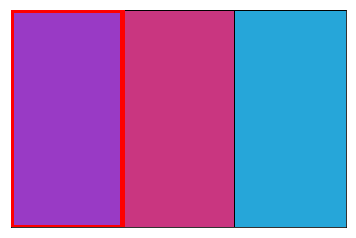

5001) Game: synth-100 Round: 2
not bright pink, not flat grey


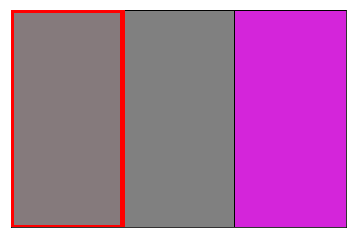

5002) Game: synth-100 Round: 3
grey


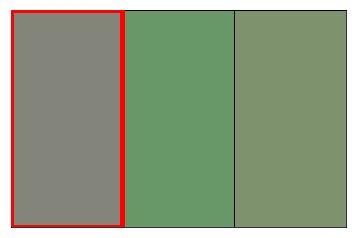

5003) Game: synth-100 Round: 4
grey


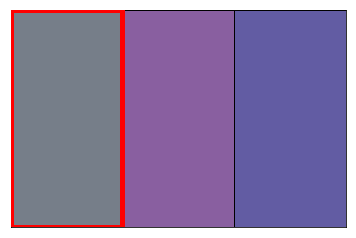

5004) Game: synth-100 Round: 5
the most green one ~ not the yellow


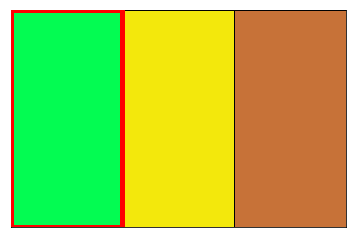

5005) Game: synth-100 Round: 6
grey


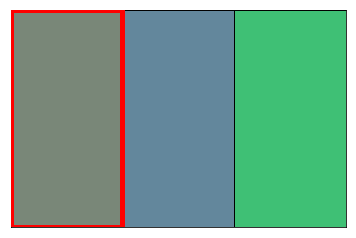

5006) Game: synth-100 Round: 7
purple


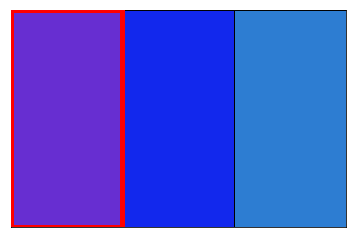

5007) Game: synth-100 Round: 8
lighter orange


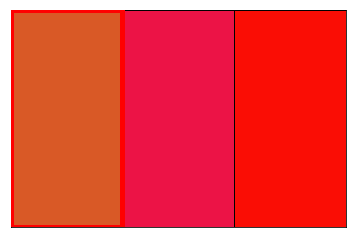

5008) Game: synth-100 Round: 9
fluorescent green


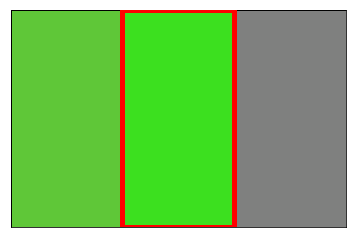

5009) Game: synth-100 Round: 10
purple


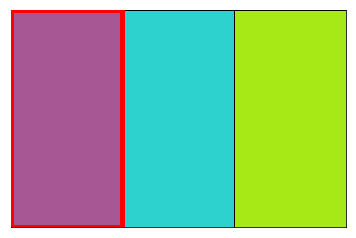

5010) Game: synth-100 Round: 11
purple


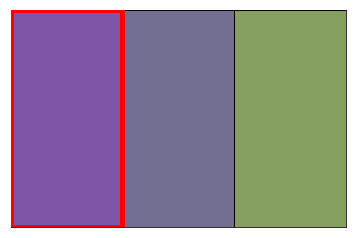

5011) Game: synth-100 Round: 12
olive


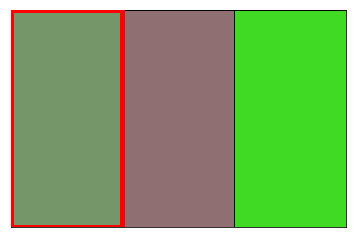

5012) Game: synth-100 Round: 13
green


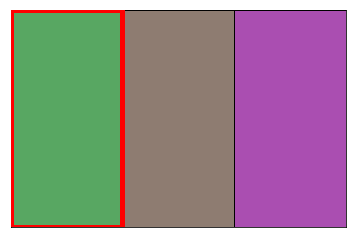

5013) Game: synth-100 Round: 14
the one that is kind of a faded green


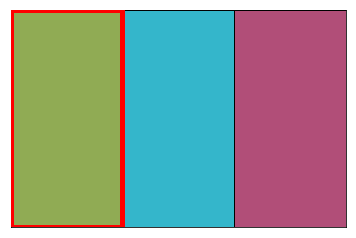

5014) Game: synth-100 Round: 15
slate


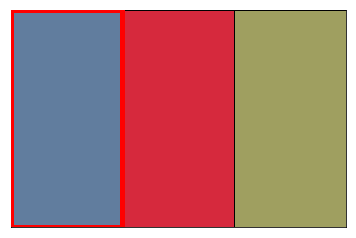

5015) Game: synth-100 Round: 16
Aqua


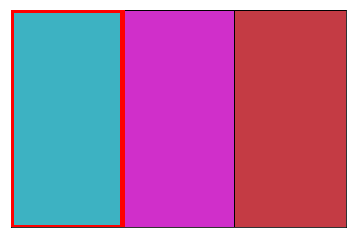

5016) Game: synth-100 Round: 17
lavender purple


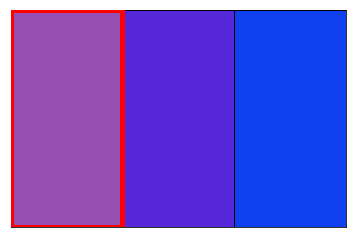

5017) Game: synth-100 Round: 18
A stormy sky


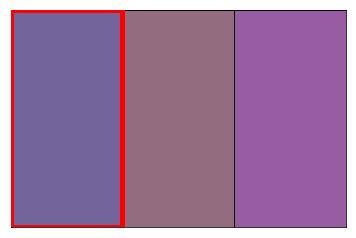

5018) Game: synth-100 Round: 19
light blue


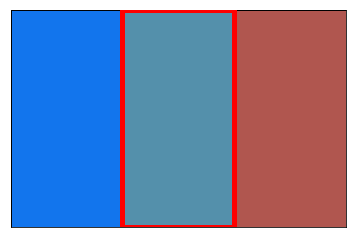

5019) Game: synth-100 Round: 20
greenest


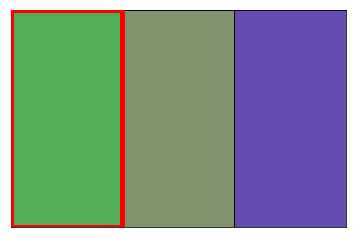

5020) Game: synth-100 Round: 21
bright yellow


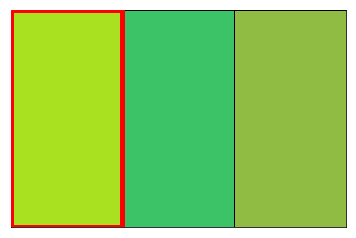

5021) Game: synth-100 Round: 22
not pink, not brownish one


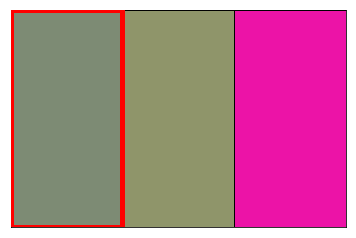

5022) Game: synth-100 Round: 23
good job ~ purple


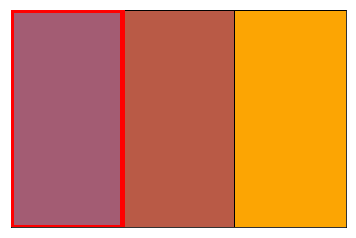

5023) Game: synth-100 Round: 24
lighter of the two pinks


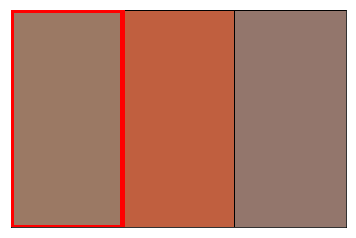

5024) Game: synth-100 Round: 25
darkest blue


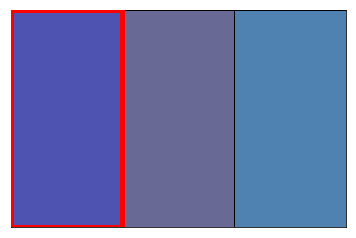

5025) Game: synth-100 Round: 26
burnt orange


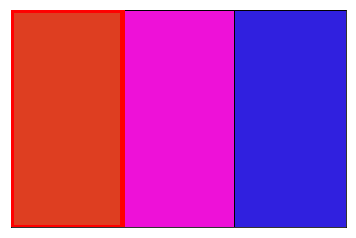

5026) Game: synth-100 Round: 27
you = awesome ~ olive


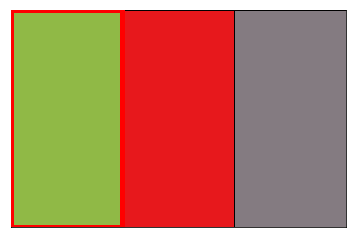

5027) Game: synth-100 Round: 28
drabest green


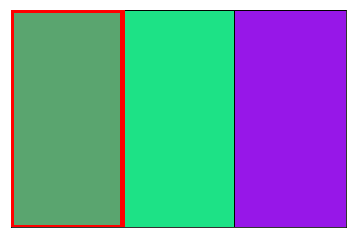

5028) Game: synth-100 Round: 29
the bright pink one


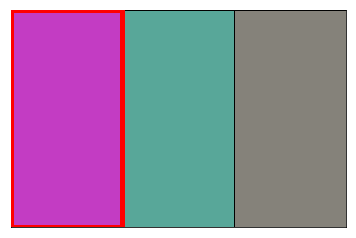

5029) Game: synth-100 Round: 30
green (Nice!)


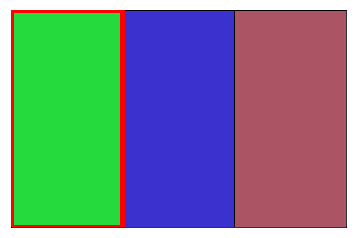

5030) Game: synth-100 Round: 31
purple


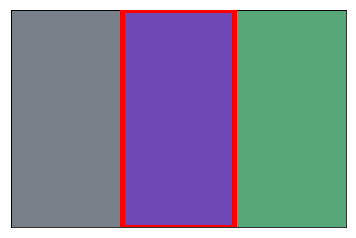

5031) Game: synth-100 Round: 32
hunting apparel


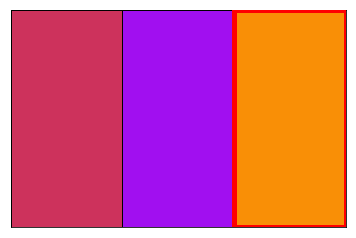

5032) Game: synth-100 Round: 33
bright green


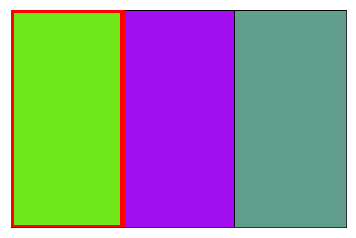

5033) Game: synth-100 Round: 34
brighter of the bright purple's


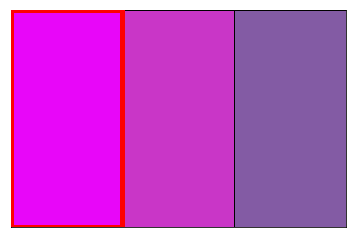

5034) Game: synth-100 Round: 35
greyist


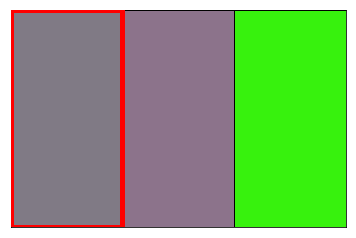

5035) Game: synth-100 Round: 36
true purple (darker, no hint of pink)


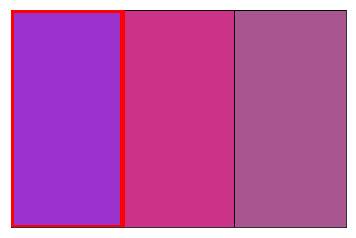

5036) Game: synth-100 Round: 37
Many little girl's favorite color


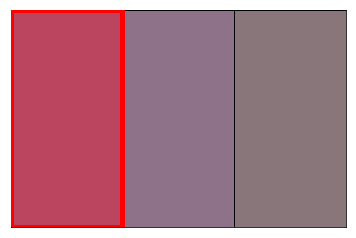

5037) Game: synth-100 Round: 38
pink


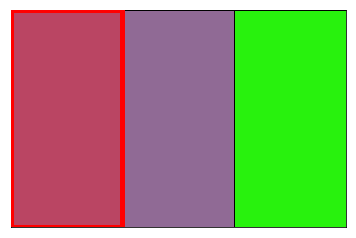

5038) Game: synth-100 Round: 39
green ~ brighter


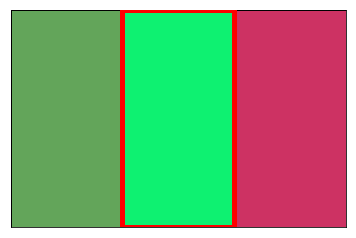

5039) Game: synth-100 Round: 40
grass


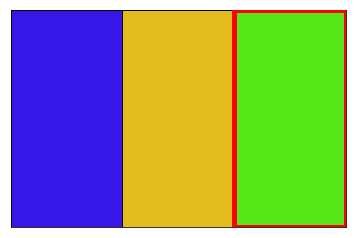

5040) Game: synth-100 Round: 41
the dullest color


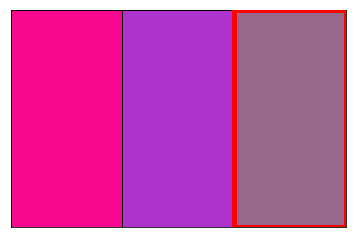

5041) Game: synth-100 Round: 42
'...rain'


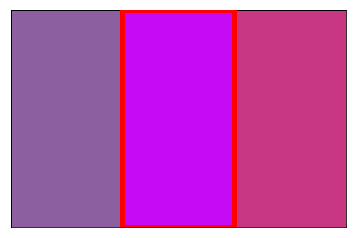

5042) Game: synth-100 Round: 43
hunting apparel


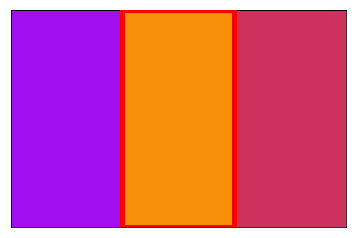

5043) Game: synth-100 Round: 44
An in between color...bluish grey, with more blue


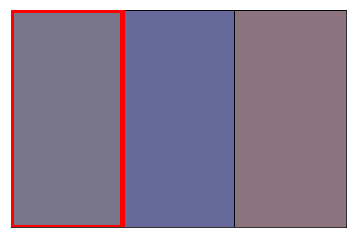

5044) Game: synth-100 Round: 45
brightest lime green


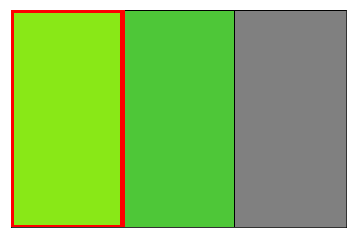

5045) Game: synth-100 Round: 46
pink/redish


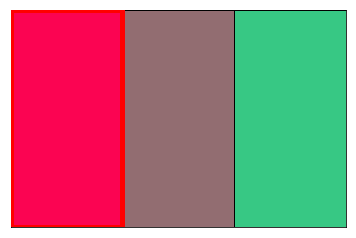

5046) Game: synth-100 Round: 47
neon green


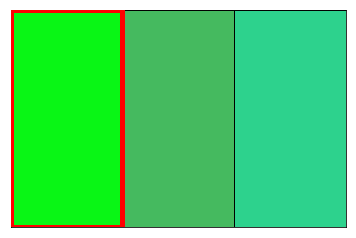

5047) Game: synth-100 Round: 48
(We had a good run!) ~ slate


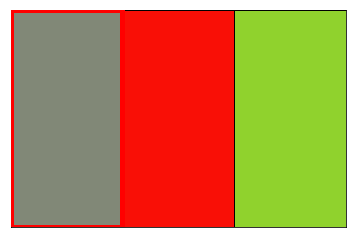

5048) Game: synth-100 Round: 49
purple


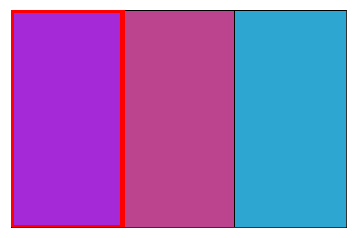

5049) Game: synth-100 Round: 50
'...rain'


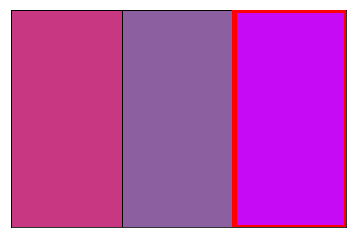

In [392]:
dev_data_synth.display_game_for_gameid("synth-100")

5000) Game: synth-100 Round: 1
'...rain'


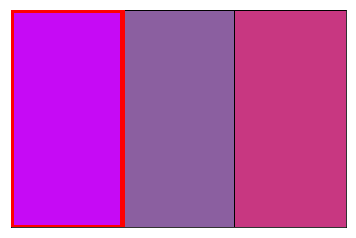

In [340]:
dev_data_synth.display_game(5000)

5000) Game: synth-100 Round: 1
'...rain'


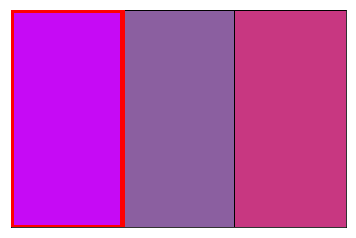

5001) Game: synth-100 Round: 2
drabest green


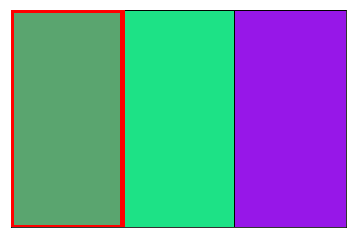

5002) Game: synth-100 Round: 3
the one that is kind of a faded green


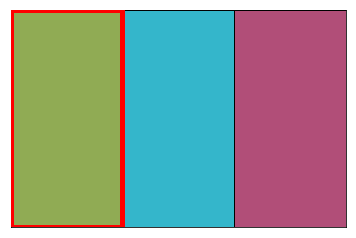

5003) Game: synth-100 Round: 4
purple


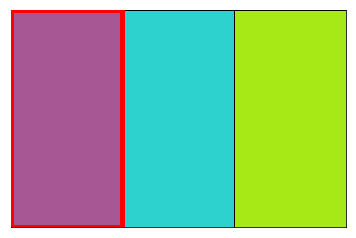

5004) Game: synth-100 Round: 5
greenest


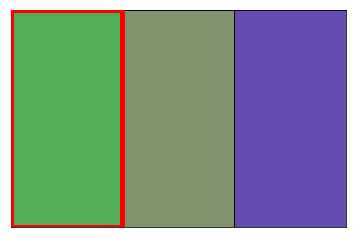

5005) Game: synth-100 Round: 6
darkest blue


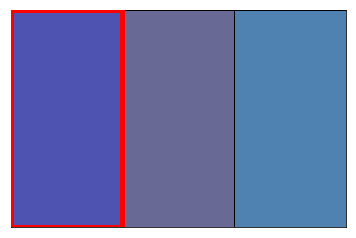

5006) Game: synth-100 Round: 7
slate


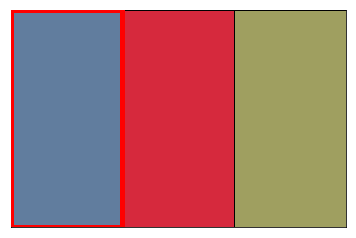

5007) Game: synth-100 Round: 8
purple


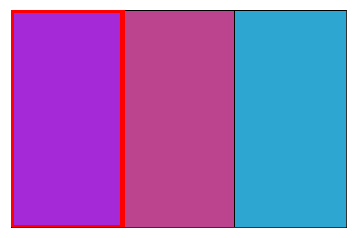

5008) Game: synth-100 Round: 9
the bright pink one


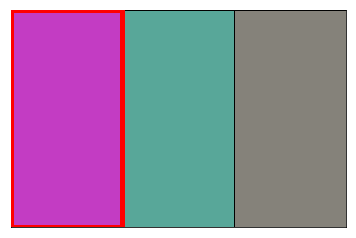

5009) Game: synth-100 Round: 10
lavender purple


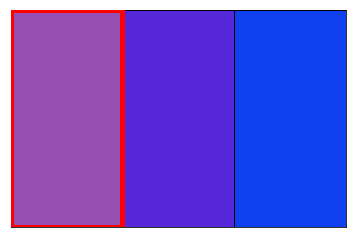

5010) Game: synth-100 Round: 11
greyist


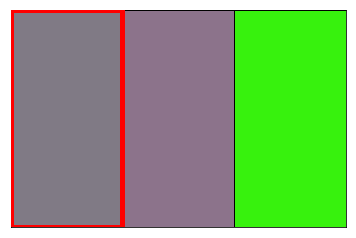

5011) Game: synth-100 Round: 12
bright green


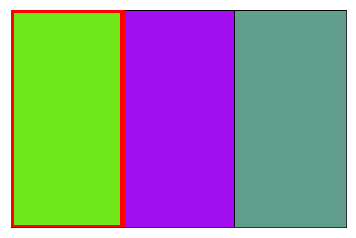

5012) Game: synth-100 Round: 13
(We had a good run!) ~ slate


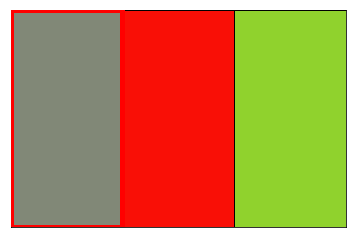

5013) Game: synth-100 Round: 14
grey


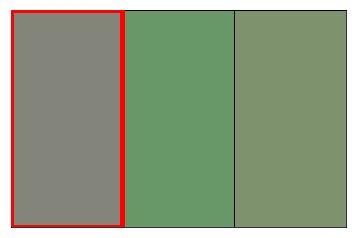

5014) Game: synth-100 Round: 15
true purple (darker, no hint of pink)


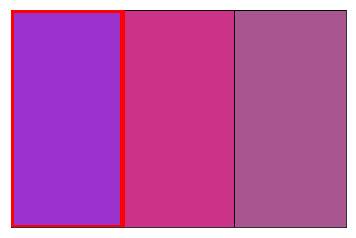

5015) Game: synth-100 Round: 16
burnt orange


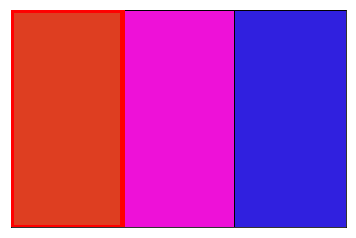

5016) Game: synth-100 Round: 17
hunting apparel


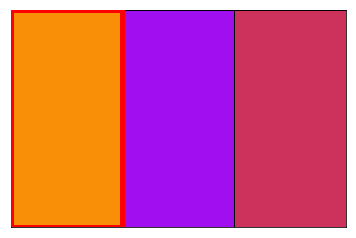

5017) Game: synth-100 Round: 18
not bright pink, not flat grey


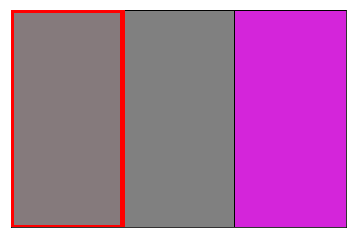

5018) Game: synth-100 Round: 19
good job ~ purple


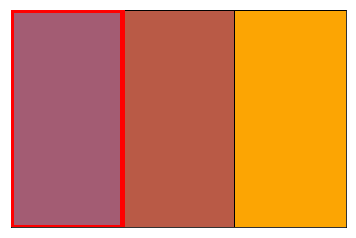

5019) Game: synth-100 Round: 20
light blue


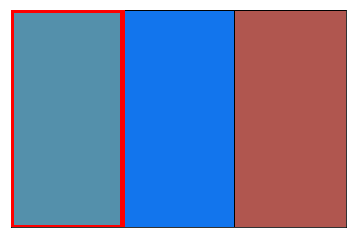

5020) Game: synth-100 Round: 21
hunting apparel


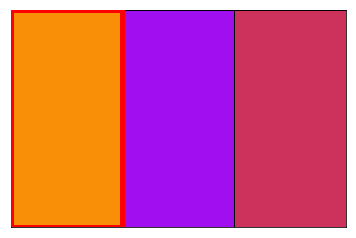

5021) Game: synth-100 Round: 22
An in between color...bluish grey, with more blue


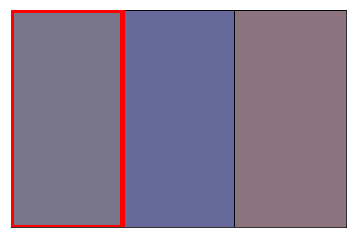

5022) Game: synth-100 Round: 23
green


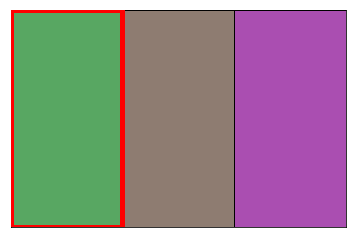

5023) Game: synth-100 Round: 24
purple


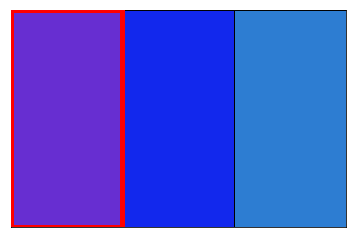

5024) Game: synth-100 Round: 25
grass


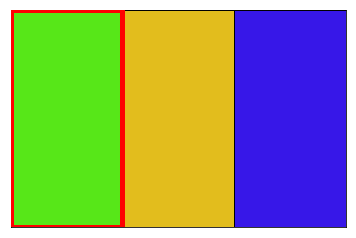

5025) Game: synth-100 Round: 26
purple


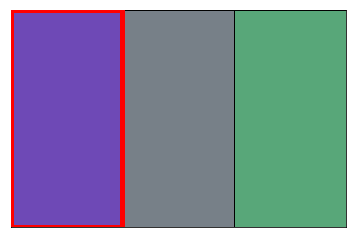

5026) Game: synth-100 Round: 27
lighter orange


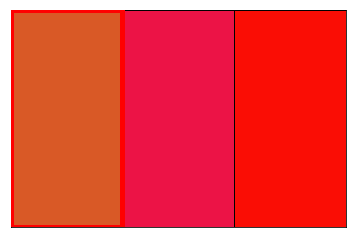

5027) Game: synth-100 Round: 28
Many little girl's favorite color


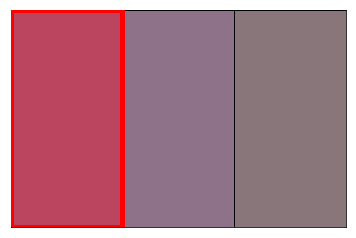

5028) Game: synth-100 Round: 29
brightest lime green


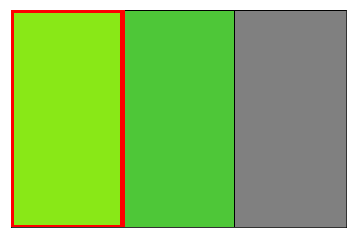

5029) Game: synth-100 Round: 30
green ~ brighter


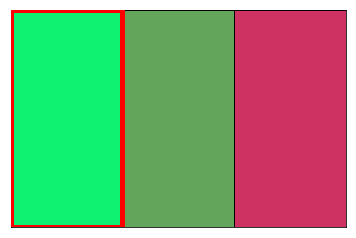

5030) Game: synth-100 Round: 31
grey


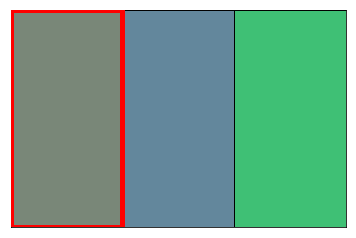

5031) Game: synth-100 Round: 32
A stormy sky


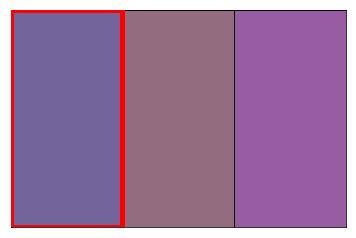

5032) Game: synth-100 Round: 33
fluorescent green


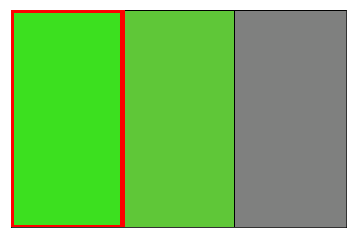

5033) Game: synth-100 Round: 34
not pink, not brownish one


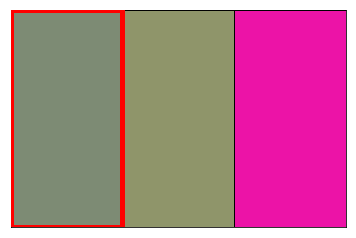

5034) Game: synth-100 Round: 35
olive


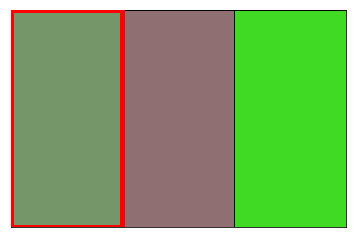

5035) Game: synth-100 Round: 36
the most green one ~ not the yellow


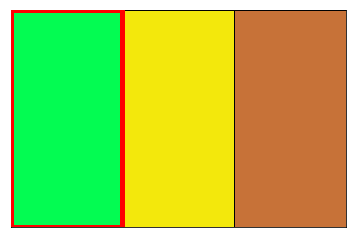

5036) Game: synth-100 Round: 37
you = awesome ~ olive


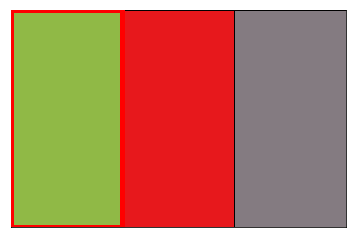

5037) Game: synth-100 Round: 38
purple


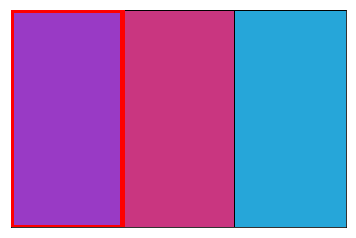

5038) Game: synth-100 Round: 39
the dullest color


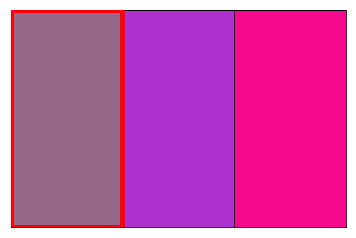

5039) Game: synth-100 Round: 40
purple


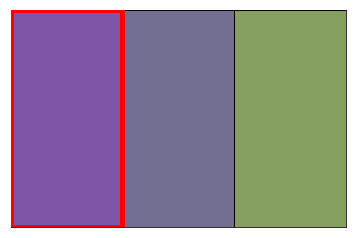

5040) Game: synth-100 Round: 41
neon green


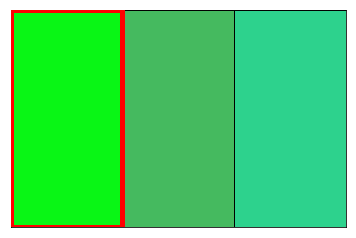

5041) Game: synth-100 Round: 42
lighter of the two pinks


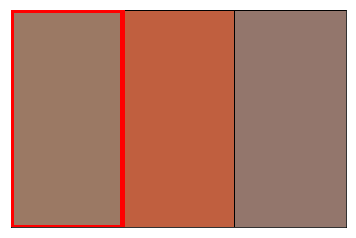

5042) Game: synth-100 Round: 43
pink


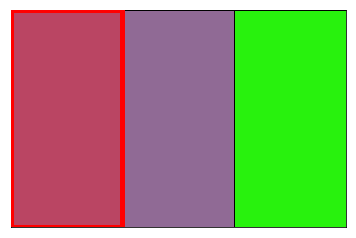

5043) Game: synth-100 Round: 44
grey


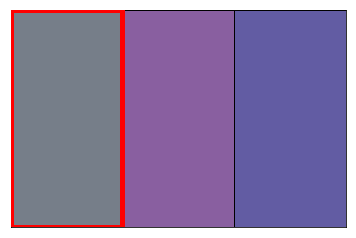

5044) Game: synth-100 Round: 45
pink/redish


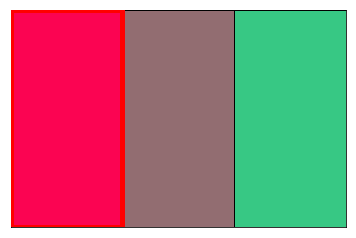

5045) Game: synth-100 Round: 46
green (Nice!)


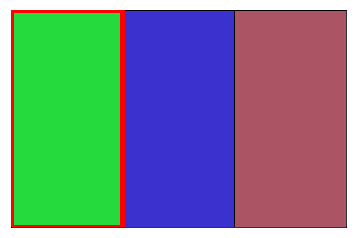

5046) Game: synth-100 Round: 47
brighter of the bright purple's


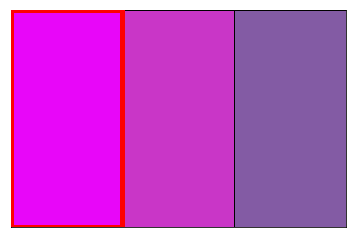

5047) Game: synth-100 Round: 48
Aqua


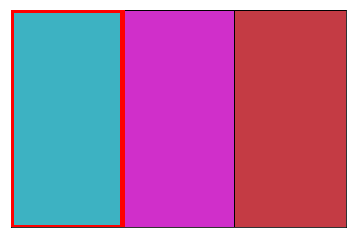

5048) Game: synth-100 Round: 49
bright yellow


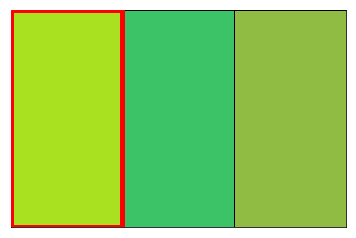

5049) Game: synth-100 Round: 50
'...rain'


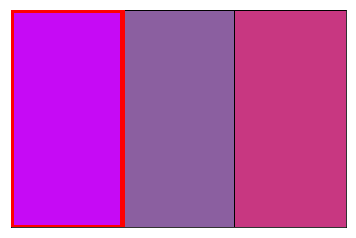

In [344]:
dev_data_synth.display_game_for_gameid("synth-100")

(array([86., 86., 86., 86., 86., 86.]),
 array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        ]),
 <a list of 6 Patch objects>)

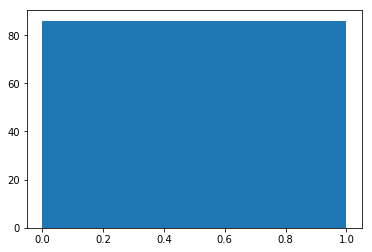

In [393]:
plt.hist(dev_data_synth.data.groupby("gameid")['numOutcome'].mean(), 6)

In [354]:
feature_handler_3 = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi)

In [394]:
feature_handler_4 = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi)

In [395]:
x = evaluate_model(dev_data_synth, feature_handler_4, model_v2, output_to_score, score_model)

(0.9804080930044121, 0.0)
Accuracy: 0.46244186046511626


In [397]:
assess_targets_tgt_v2_s, model_outputs_v2_s, model_scores_v2_s, true_scores_grouped_v2_s, model_scores_grouped_v2_s = x

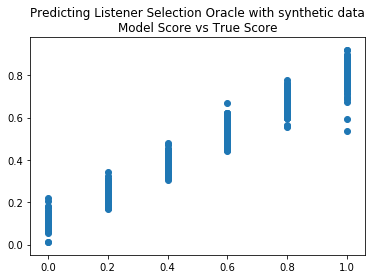

In [398]:
plt.scatter(true_scores_grouped_v2_s, model_scores_grouped_v2_s)
plt.title("Predicting Listener Selection Oracle with synthetic data\nModel Score vs True Score")
plt.show()

In [396]:
stats.pearsonr(true_scores_grouped_v2_s, model_scores_grouped_v2_s)

(0.9804080934155447, 0.0)

In [10]:
# literal listener v1
train = False
model_file_v1 = "../model/literal_listener_5epoch_endings_tkn.params"

model_v1 = LiteralListener(CaptionEncoder, num_epochs=5)
model_v1.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file))
    #model_v1.fit(train_features, train_targets)
    #model_v1.save_model(model_file)
else:
    print("Loading pretrained model")
    model_v1.load_model(model_file_v1)

NameError: name 'embed_dim' is not defined

In [399]:
x = evaluate_model(dev_data_synth, feature_handler_4, model_v1, output_to_score, score_model)

(0.9835602250611073, 0.0)
Accuracy: 0.4633333333333333


In [366]:
assess_targets_tgt_v1_s, model_outputs_v1_s, model_scores_v1_s, true_scores_grouped_v1_s, model_scores_grouped_v1_s = x

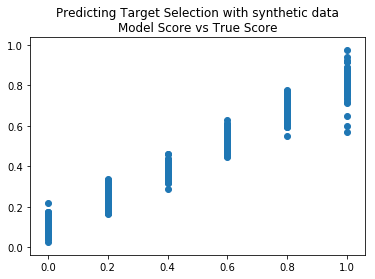

In [368]:
plt.scatter(true_scores_grouped_v1_s, model_scores_grouped_v1_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [369]:
stats.spearmanr(true_scores_grouped_v1_s, model_scores_grouped_v1_s)

SpearmanrResult(correlation=0.982076573276505, pvalue=0.0)

In [345]:
dev_data_synth[5017].target_idx

0

In [328]:
synth_data[0].index

3

In [331]:
dev_data.data.head()

,gameid,clkTime,roundNum,condition,clickStatus,clickColH,clickColS,clickColL,clickLocS,clickLocL,...,msgTime,role,contents,workerid_uniq,numOutcome,numRawWords,numRawChars,numCleanChars,numCleanWords,source
0,2641-2,1.476490e+12,1,split,target,48,13,50,2,1,...,1.476490e+12,speaker,gray,619.0,1.0,1,4,4.0,1.0,human
1,2641-2,1.476490e+12,2,split,target,66,26,50,3,3,...,1.476490e+12,speaker,green,619.0,1.0,1,5,5.0,1.0,human
2,2641-2,1.476490e+12,3,far,target,336,24,50,2,2,...,1.476490e+12,speaker,lavender ~ the duller one,619.0,1.0,3,12,9.0,2.0,human
3,2641-2,1.476490e+12,4,split,target,172,60,50,1,1,...,1.476490e+12,speaker,the brighter blue,619.0,1.0,3,15,12.0,2.0,human
4,2641-2,1.476490e+12,5,far,target,41,71,50,1,2,...,1.476490e+12,speaker,yellow,619.0,1.0,1,6,6.0,1.0,human


In [315]:
len(synth_data)/50/6

86.0

In [308]:
condition_counter_correct//3

4320

In [304]:
[len(x) for x in fake_entries]

[10254, 8640, 4718]

In [305]:
[len(x) for x in correct_entries]

[5127, 4320, 4718]

In [311]:
(3*4320)

12960

In [443]:
def create_synth_data(fake_entries, correct_entries, num_divisions = 5, filename = "synthdata"):
    synth_data = []
    condition_counter_fake = 0
    condition_counter_correct = 0
    min_condition_samples = 4173 # train # dev - 4320 # we have the fewest number of correct close samples
    num_games = 3*min_condition_samples//((num_divisions + 1) * 25)
    
    # let's divide into fifths
    for i in range(num_divisions + 1): # 0...num_divisions inclusive
        for game_id in range(num_games): # 150 size of each group required over whole game over dataset, 3*4320 
            synth_game = []
            for j in range(50):
                if j < (50/num_divisions) * i: # add fake stuff
                    synth_game.append(fake_entries[condition_counter_fake % 3][condition_counter_fake // 3])
                    condition_counter_fake += 1
                else: # add real stuff
                    synth_game.append(correct_entries[condition_counter_correct % 3][condition_counter_correct // 3])
                    condition_counter_correct += 1
            random.shuffle(synth_game)
            synth_data.extend(synth_game)
    
    # construct a dataframe and populate it (this takes a long time)
    synth_data_df = pd.DataFrame(index=list(range(len(synth_data))), columns=dev_data.data.columns)

    for round_counter, sde in enumerate(synth_data):
        idx = sde.index
        game_id = "synth-%d"%(round_counter // 50)
        synth_data_df.loc[round_counter] = dev_data.data.loc[idx]
        synth_data_df.loc[round_counter, "gameid"] = game_id
        synth_data_df.loc[round_counter, "roundNum"] = round_counter % 50 + 1 # they one index rounds so we do the same...
        synth_data_df.loc[round_counter, "outcome"] = sde.outcome
        synth_data_df.loc[round_counter, "numOutcome"] = 1 if sde.outcome else 0
        
    with open("../data/entries/%s.pkl"%filename, "wb") as pkl_file:
        pkl.dump(synth_data, pkl_file)
    synth_data_df.to_csv("../data/csv/%s.csv"%filename, header=True, index=False)
    monroe_synth_data = MonroeData("../data/csv/%s.csv"%filename, "../data/entries/%s.pkl"%filename)
    return monroe_synth_data

In [425]:
dev_data_synth_10 = create_synth_data(fake_entries, correct_entries, num_divisions=10, filename = "dev_corpus_synth_10fold")

In [426]:
feature_handler_5 = FeatureHandler(train_data, dev_data_synth_10, caption_phi, color_phi)

In [427]:
x = evaluate_model(dev_data_synth_10, feature_handler_5, model_v1, output_to_score, score_model)
assess_targets_tgt_v1_s, model_outputs_v1_s, model_scores_v1_s, true_scores_grouped_v1_s, model_scores_grouped_v1_s = x

(0.9803888168043288, 0.0)
Accuracy: 0.46336557059961314


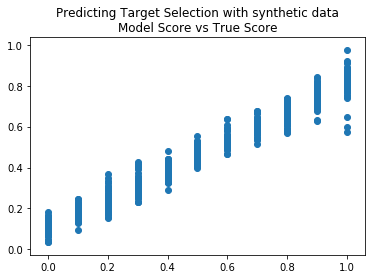

In [428]:
plt.scatter(true_scores_grouped_v1_s, model_scores_grouped_v1_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [429]:
x = evaluate_model(dev_data_synth_10, feature_handler_5, model_v2, output_to_score, score_model)
assess_targets_tgt_v2_s, model_outputs_v2_s, model_scores_v2_s, true_scores_grouped_v2_s, model_scores_grouped_v2_s = x

(0.9773441866726907, 0.0)
Accuracy: 0.46259187620889747


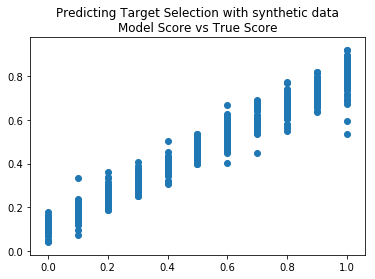

In [432]:
plt.scatter(true_scores_grouped_v2_s, model_scores_grouped_v2_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [447]:
random.random()

0.7328506028564533

In [434]:
def generate_synth_entries(monroe_df):
    # get correct entries
    correct_entries = list(filter(lambda de: de.target_idx == de.click_idx, monroe_df.entries))
    
    fake_far_entries   = []
    fake_close_entries = []
    fake_split_entries = []
    
    for de in correct_entries:
        # if close or far, basically symmetric so add both (far fakes will be misleading, close fakes will be ambiguous)
        if de.condition == "far" or de.condition == "close":
            for i in range(1,3):
                de_cp = copy.deepcopy(de)
                de_cp.click_idx = i
                de_cp.colors[0], de_cp.colors[i] = de_cp.colors[i], de_cp.colors[0] # swap target and clicked colors
                #de_cp.target_idx = i # i = 1, 2
                de_cp.outcome = False
                if de.condition == "far":
                    if de.index % 2 == 0:
                        fake_far_entries.append(de_cp)
                    else:
                        fake_far_entries.insert(0, de_cp)
                else: # close
                    if de.index % 2 == 0:
                        fake_close_entries.append(de_cp)
                    else:
                        fake_close_entries.insert(0, de_cp)
        # we have to be a bit more careful, because the fake target really should
        # be the one that is closest to the target
        elif de.condition == "split":
            # get index to lookup in dataframe
            idx = de.index
            de_cp = copy.deepcopy(de)
            de_cp.outcome = False
            click_idx = 2 # assume the close one is the 2nd distractor
            if monroe_df.data["targetD1Diff"][idx] < monroe_df.data["targetD2Diff"][idx]:
                # D1 is the close distractor (and new target) - corresponds to color at index 1
                click_idx = 1
            de_cp.click_idx = click_idx
            de_cp.colors[0], de_cp.colors[click_idx] = de_cp.colors[click_idx], de_cp.colors[0]
            fake_split_entries.append(de_cp)
    
    # we also need the correct versions of these tasks
    correct_entries_cond = [[], [], []]
    cond_map = {"far": 0, "close": 1, "split": 2}
    for de in correct_entries:
        correct_entries_cond[cond_map[de.condition]].append(de)
    return [fake_far_entries, fake_close_entries, fake_split_entries], correct_entries_cond

In [435]:
train_data_synth_fake_entries, train_data_synth_correct_entries = generate_synth_entries(train_data)

In [444]:
train_data_synth_10 = create_synth_data(train_data_synth_fake_entries, train_data_synth_correct_entries, num_divisions=10, filename = "train_corpus_synth_10fold")

In [ ]:
# len(train_data_synth_fake_entries[0])

In [442]:
len(train_data_synth_correct_entries[1])

4173

# Making new metric: Literal Listener

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
dev_data_synth_10 = MonroeData("../data/csv/dev_corpus_synth_10fold.csv", "../data/entries/dev_corpus_synth_10fold.pkl")

In [64]:
eval_df = None
def score_model(test_data, scores, regressor=stats.pearsonr, groupbycond=False):
    """
    Assume scores are in the same order as the test data (i.e. 0th row is 0th score) and calculates a regression
    between the scores of the individual games and the scores from the model
    """
    global eval_df
    relevant_columns = ["gameid", "roundNum", "numOutcome", "workerid_uniq", "condition",
                        "msgTime", "clkTime", "numCleanWords", "numCleanChars"]
#     if speaker == Speaker.BY_WORKER_ID:
#         relevant_columns.append(Speaker.BY_WORKER_ID.value)

# #     if score == Score.COMPOSITE:
#         # no support for this yet but probably also need:
#         relevant_columns.extend(["contents", "clkTime", "msgTime"])

    eval_df = test_data.data[relevant_columns].copy()
    eval_df["model_scores"] = scores # why we need scores to be in same order as rows

    # true_scores = eval_df.groupby("gameid").numOutcome.mean()
    mean_scores = eval_df.groupby("gameid").numOutcome.mean()
    mean_msgTime = eval_df.groupby("gameid").msgTime.mean()
    mean_clkTime = eval_df.groupby("gameid").clkTime.mean()
    mean_numCleanWords = eval_df.groupby("gameid").numCleanWords.mean()
    mean_numCleanChars = eval_df.groupby("gameid").numCleanChars.mean()
    
    if groupbycond:
        mean_scores = eval_df.groupby(["gameid", "condition"]).numOutcome.mean()
        mean_msgTime = eval_df.groupby(["gameid", "condition"]).msgTime.mean()
        mean_clkTime = eval_df.groupby(["gameid", "condition"]).clkTime.mean()
        mean_numCleanWords = eval_df.groupby(["gameid", "condition"]).numCleanWords.mean()
        mean_numCleanChars = eval_df.groupby(["gameid", "condition"]).numCleanChars.mean()
    
    true_scores = mean_scores / mean_clkTime / mean_numCleanWords
    max_score = true_scores.max()
    true_scores /= max_score # normalize the scores

#     if score == score.SIMPLE:
#         # calculate scores as the mean of the number of successful utterances
#         # a speaker has
#         true_scores = eval_df.groupby(speaker.value).numOutcome.mean()
#     else:
#         true_scores = calculate_scores(eval_df, score)

    # calculate a model score
    #model_scores = eval_df.groupby("gameid").model_scores.mean()
    model_scores = eval_df.groupby("gameid").model_scores.mean()
    if groupbycond:
        model_scores = eval_df.groupby(["gameid", "condition"]).model_scores.mean()

    result = regressor(true_scores, model_scores)
    print(result)
    return result, true_scores, model_scores

In [65]:
# literal listener v1
train = False
model_file_v1 = "../model/literal_listener_5epoch_endings_tkn.params"

model_v1 = LiteralListener(CaptionEncoder, num_epochs=5)
model_v1.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file))
    #model_v1.fit(train_features, train_targets)
    #model_v1.save_model(model_file)
else:
    print("Loading pretrained model")
    model_v1.load_model(model_file_v1)

Loading pretrained model


In [66]:
train = False
model_file_v2 = "../model/literal_listener_listener_click_5epoch_endings_tkn.params"

model_v2 = LiteralListener(CaptionEncoder, num_epochs=30)
model_v2.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
             color_dim = color_dim)

if train:
    print("Training model and saving to {}:".format(model_file_v2))
    model_v2.fit(train_features, train_targets)
    model_v2.save_model(model_file_v2)
else:
    print("Loading pretrained model")
    model_v2.load_model(model_file_v2)

Loading pretrained model


In [67]:
feature_handler_5 = FeatureHandler(train_data, dev_data_synth_10, caption_phi, color_phi)

In [68]:
x = evaluate_model(dev_data_synth_10, feature_handler_5, model_v1, output_to_score, score_model)
assess_targets_tgt_v1_s, model_outputs_v1_s, model_scores_v1_s, true_scores_grouped_v1_s, model_scores_grouped_v1_s = x

(0.9447046164282245, 1.5582149691850004e-251)
(0.9447046164282245, 1.5582149691850004e-251)
Accuracy: 0.4471953578336557


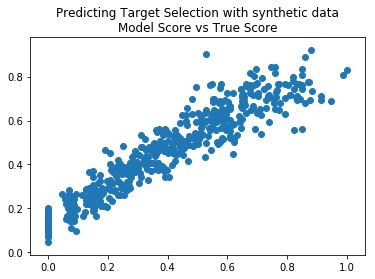

In [69]:
plt.scatter(true_scores_grouped_v1_s, model_scores_grouped_v1_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [70]:
x2 = evaluate_model(dev_data_synth_10, feature_handler_5, model_v2, output_to_score, score_model)
assess_targets_tgt_v2_s, model_outputs_v2_s, model_scores_v2_s, true_scores_grouped_v2_s, model_scores_grouped_v2_s = x2

(0.9410051219709074, 1.673708179274916e-244)
(0.9410051219709074, 1.673708179274916e-244)
Accuracy: 0.43705996131528047


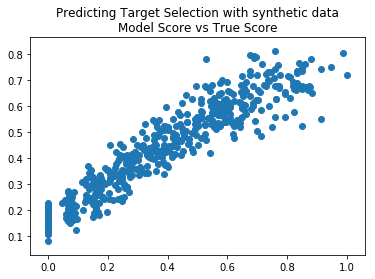

In [71]:
plt.scatter(true_scores_grouped_v2_s, model_scores_grouped_v2_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

# Pragmatic Listener

In [74]:
#literal listener: use model_v1 trained above

#literal speaker:
epochs=30; color_in_dim = 54; color_dim = 100; embed_dim = 100; hidden_dim = 100; lr = 0.004
ls_model_glove = LiteralSpeaker(CaptionGenerator, optimizer=torch.optim.Adam, lr=lr, num_epochs=epochs)
ls_model_glove.init_model(color_in_dim=color_in_dim, color_dim=color_dim,
                  vocab_size=caption_phi.caption_indexer.size, embed_dim=embed_dim,
                  speaker_hidden_dim=hidden_dim)
ls_model_glove.load_model("../model/literal_speaker_30epochGLOVE.params")

model_p = PragmaticListener(model_v1, ls_model_glove)
# x = evaluate_model(dev_data_synth_10, feature_handler_5, model_p, output_to_score, score_model)

In [75]:
#confirm models are loaded
print(model_v1.predict([train_features[0]]))
print(model_p.predict([train_features[0]]))

[[-24.25899124  -2.09427118  -0.13143063]]
[[-13.21425893  -1.11035431  -0.39964812]]


In [76]:
xp = evaluate_model(dev_data_synth_10, feature_handler_5, model_p, output_to_score, score_model)

(0.9371370634147823, 1.2715182065384073e-237)
(0.9371370634147823, 1.2715182065384073e-237)
Accuracy: 0.43709864603481624


In [77]:
assess_targets_tgt_p_s, model_outputs_p_s, model_scores_p_s, true_scores_grouped_p_s, model_scores_grouped_p_s = xp

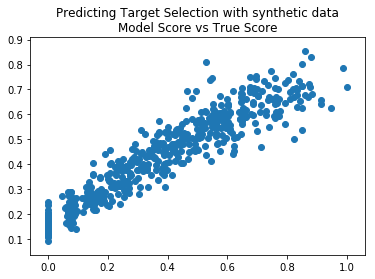

In [78]:
plt.scatter(true_scores_grouped_p_s, model_scores_grouped_p_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

In [79]:
model_p2 = PragmaticListener(model_v1, ls_model_glove, alpha=1, sample=3)

In [80]:
xp2 = evaluate_model(dev_data_synth_10, feature_handler_5, model_p2, output_to_score, score_model)

(0.9314472625407079, 2.9360315340716363e-228)
(0.9314472625407079, 2.9360315340716363e-228)
Accuracy: 0.43106382978723407


In [81]:
assess_targets_tgt_p2_s, model_outputs_p2_s, model_scores_p2_s, true_scores_grouped_p2_s, model_scores_grouped_p2_s = xp2

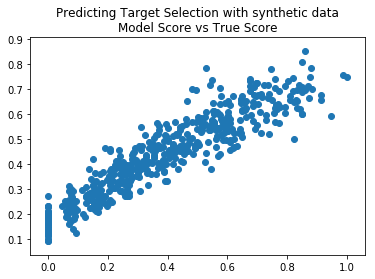

In [82]:
plt.scatter(true_scores_grouped_p2_s, model_scores_grouped_p2_s)
plt.title("Predicting Target Selection with synthetic data\nModel Score vs True Score")
plt.show()

# Imaginative Listener

In [112]:
from skimage import io, color

In [102]:
# Model 3: third simplest version of the model - generate target color from description AND distractors
# (but just use fully connected layers rather than an RNN to encode the colors
class ColorGeneratorWithDistractorsLinear(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, color_in_dim, color_hidden_dim, weight_matrix=None):
        super(ColorGeneratorWithDistractorsLinear, self).__init__()
        # Embedding/LSTM for words
        self.embed = nn.Embedding(vocab_size, embed_dim)
        if weight_matrix is not None:
            self.embed.load_state_dict({'weight': weight_matrix})
            
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        
        # Linear layers for colors
        #self.color_rnn = nn.RNN(color_in_dim, color_hidden_dim, bidirectional=True, batch_first=True)
        self.color_encode = nn.Linear(2*color_in_dim, color_hidden_dim)
        
        # now generate color from embedding dim:
        # two linear layers to allow for some non-linear function of the hidden state elements
        # if this leads to overfitting I'll take it out
        self.linear1 = nn.Linear(2*hidden_dim + color_hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 3) # 3 for rgb
        
        self.hidden_dim = hidden_dim
        self.color_hidden_dim = color_hidden_dim
        
    def forward(self, caption, colors):
        # get caption encodings
        embeddings = self.embed(caption)
        output, _ = self.lstm(embeddings)
        
        # get color encodings
        colors = colors.reshape(1, 1, -1)
        color_encodings = nn.functional.relu(self.color_encode(colors))
        color_encodings = color_encodings.squeeze(0)
        
        # only care about vector of last sequence
        output = torch.cat((output[:, -1, :self.hidden_dim],
                            output[:, 0, self.hidden_dim:]), 1)

        # combine colors and caption
        combined_output = torch.cat((output, color_encodings), 1)
        output = self.linear1(combined_output)
        output = nn.functional.relu(output)
        output = nn.functional.softmax(self.linear2(output), dim=1)
        return output

In [93]:
class ImaginativeListener(PytorchModel):
    def __init__(self, model, use_color=True, **kwargs):
        super(ImaginativeListener, self).__init__(model, **kwargs)
        self.use_color = use_color
        
    def train_iter(self, caption_tensor, color_tensor, target_tensor, optimizer, criterion):
        optimizer.zero_grad()
        loss = 0
        
        # not using colors at the moment
        if self.use_color:
            color_tensor = color_tensor[:, 1:3, :] # don't include the target at index 0
            model_output = self.model(caption_tensor, color_tensor)
        else:
            model_output = self.model(caption_tensor)
            
        if isinstance(criterion, nn.MSELoss):
            loss += criterion(model_output, target_tensor.type(torch.FloatTensor))
        else:
            model_output = model_output.type(torch.DoubleTensor)
            label = torch.tensor(1, dtype=torch.double)
            loss += criterion(model_output, target_tensor.detach(), label)
        loss.backward()
        optimizer.step()
        
        return loss
        
    def predict(self, X):
        model_outputs = np.empty([len(X), 3])
        self.model.eval()
        with torch.no_grad():
            for i, feature in enumerate(X):
                caption, colors = feature
                caption_tensor = torch.tensor([caption], dtype=torch.long)
                color_tensor = torch.tensor([colors], dtype=torch.float)
                if self.use_color:
                    color_tensor = color_tensor[:, 1:3, :] # don't include the target
                    model_output = self.model(caption_tensor, color_tensor)
                else:
                    model_output = self.model(caption_tensor)
                    
                model_output_np = model_output.view(-1).numpy()
                model_outputs[i] = model_output_np
        return np.array(model_outputs)

In [117]:
# author: Chris Potts
def glove2dict(src_filename):
    """GloVe Reader.
    Parameters
    ----------
    src_filename : str
        Full path to the GloVe file to be processed.
    Returns
    -------
    dict
        Mapping words to their GloVe vectors.
    """
    data = {}
    with open(src_filename, encoding='utf8') as f:
        while True:
            try:
                line = next(f)
                line = line.strip().split()
                data[line[0]] = np.array(line[1: ], dtype=np.float)
            except StopIteration:
                break
            except UnicodeDecodeError:
                pass
    return data

In [125]:
def assess_model(model):
    # get model outputs
    assess_model_outputs = model.predict(assess_features)
    
    # first do delta e check
    assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]
    #_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth, assess_model_scores)
    _, close_scores, split_scores, far_scores, all_scores = score_model(dev_data_synth, assess_model_scores, score=Score.CONDITION, return_df=True)
#     plt.scatter(true_scores_grouped, model_scores_grouped)
#     plt.show()
    
    # next do accuracy check
    assess_model_scores_eval = [output_to_score_closest_color(assess_model_outputs[i], assess_targets_eval[i]) for i in range(len(assess_model_outputs))]
    #_, true_scores_grouped_eval, model_scores_grouped_eval = score_model(dev_data_synth, assess_model_scores_eval)
    _, close_scores_eval, split_scores_eval, far_scores_eval, all_scores_eval = score_model(dev_data_synth, assess_model_scores_eval, score=Score.CONDITION, return_df=True)
    close_scores["model_scores_eval"] = close_scores_eval["model_scores"]
    split_scores["model_scores_eval"] = split_scores_eval["model_scores"]
    far_scores["model_scores_eval"] = far_scores_eval["model_scores"]
    all_scores["model_scores_eval"] = all_scores_eval["model_scores"]
    
    close_scores = close_scores.groupby("gameid").mean()
    split_scores = split_scores.groupby("gameid").mean()
    far_scores = far_scores.groupby("gameid").mean()
    all_scores = all_scores.groupby("gameid").mean()
    
    find_correlation(close_scores, "red", "Close")
    find_correlation(split_scores, "blue", "Split")
    find_correlation(far_scores, "green", "Far")
    find_correlation(all_scores, "black", "All")
    
    # all_scores_eval['model_outputs'] = assess_model_outputs
    return all_scores_eval, assess_model_outputs
    
#     plt.scatter(true_scores_grouped_eval, model_scores_grouped_eval)
#     plt.show()

In [118]:
glove100 = glove2dict("../../cs224u/data/glove.6B/glove.6B.100d.txt")

In [119]:
# from https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
weight_matrix = np.empty((feature_handler.caption_featurizer.caption_indexer.size, 100))
for i, word in feature_handler.caption_featurizer.caption_indexer.idx2word.items():
    weight_matrix[i] = glove100.get(word, np.random.normal(scale=0.6, size=(100, )))

In [120]:
MSELossSum = lambda: nn.MSELoss(reduction='sum')
model_im_glove = ImaginativeListener(ColorGeneratorWithDistractorsLinear, criterion=MSELossSum, 
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=True)
model_im_glove.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                color_in_dim=54, color_hidden_dim=100, weight_matrix=torch.tensor(weight_matrix))

In [122]:
train = False
model_file_im_glove = "../model/imaginative_listener_with_distractors_linear100hd5epoch_GLOVE_MSE.params"

if train:
    print("Training model and saving to {}:".format(model_file))
    model_im_glove.fit(train_features, train_targets)
    model_im_glove.save_model(model_file_im2)
else:
    print("Loading pretrained model")
    model_im_glove.load_model(model_file_im2)

Loading pretrained model


In [109]:
output_to_score_cosine = lambda output, target: 2 - scipy.spatial.distance.cosine(output, target)
output_to_score_de = lambda output, target: delta_e_dist(output, target)

def delta_e_dist(color1, color2):
    """color1 and color2 are in rgb space"""
    # do some nice integer conversions
    color1 = np.round(255*color1)
    color2 = np.round(255*color2)
    # convert colors to lab
    color1_lab = color.rgb2lab(np.array([[color1]], dtype=np.uint8)).flatten()
    color2_lab = color.rgb2lab(np.array([[color2]], dtype=np.uint8)).flatten()
    
    # compute Delta E CIEDE 2000 distance
    return color.deltaE_ciede2000(color1_lab, color2_lab)

In [130]:
def all_color_target(data_entry):
    color_array, _ = color_phi.to_color_lists(data_entry.colors, normalized=True)
    return np.array(color_array)

feature_handler_eval = FeatureHandler(train_data, dev_data_synth_10, caption_phi, color_phi, target_fn=all_color_target,
                                randomized_colors=False)

In [132]:
def output_to_score_closest_color(model_output, target):
    distances = np.array([delta_e_dist(model_output, color) for color in target])
    return np.argmin(distances) == 0 # target is closest

In [131]:
assess_features = feature_handler_eval.test_features()
assess_targets = feature_handler_eval.test_targets()

In [133]:
# using closest color
assess_model_scores = [output_to_score_closest_color(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]

In [175]:
# using de
assess_model_scores = [output_to_score_de(assess_model_outputs[i], assess_targets[i]) for i in range(len(assess_model_outputs))]

In [138]:
_, true_scores_grouped, model_scores_grouped = score_model(dev_data_synth_10, assess_model_scores)

(0.8564912607001747, 4.981924900611038e-150)


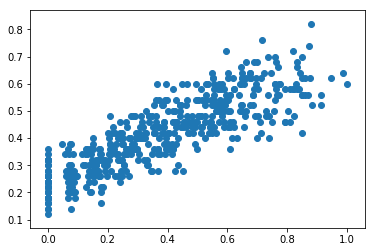

In [139]:
plt.scatter(true_scores_grouped, model_scores_grouped)

# Visualize with Conditions

In [176]:
relevant_columns = ["gameid", "roundNum", "numOutcome", "condition"]
eval_df = dev_data_synth_10.data[relevant_columns].copy()

_, true_scores_grouped_cond, model_scores_grouped_cond = score_model(dev_data_synth_10, assess_model_scores, groupbycond=True)

# eval_df["model_scores_dlg"] = assess_model_scores
# eval_scores_split = eval_df.groupby(['gameid', 'condition']).mean()

(-0.19963098394232448, 2.0933882749803276e-15)


In [177]:
colors = []
for cond in true_scores_grouped_cond.index.get_level_values(1).values:
    if cond == 'close':
        colors.append('red')
    elif cond == 'split':
        colors.append('blue')
    else:
        colors.append('green')

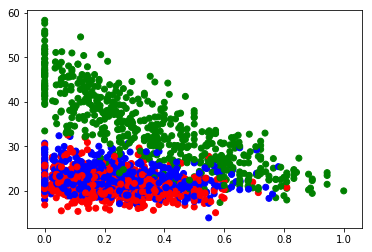

In [179]:
# Imaginative listener eval results by conditions
plt.scatter(true_scores_grouped_cond, model_scores_grouped_cond, c=colors)
plt.show()

In [181]:
relevant_columns = ["gameid", "roundNum", "numOutcome", "condition"]
eval_df_lit = dev_data_synth_10.data[relevant_columns].copy()

_, true_scores_grouped_cond, model_scores_grouped_cond = score_model(dev_data_synth_10, model_scores_v2_s, groupbycond=True)

# eval_df_lit["model_scores_dlg"] = model_scores_v2_s
# eval_scores_split_lit = eval_df_lit.groupby(['gameid', 'condition']).mean()

(0.836993221752449, 0.0)


In [182]:
colors = []
for cond in true_scores_grouped_cond.index.get_level_values(1).values:
    if cond == 'close':
        colors.append('red')
    elif cond == 'split':
        colors.append('blue')
    else:
        colors.append('green')

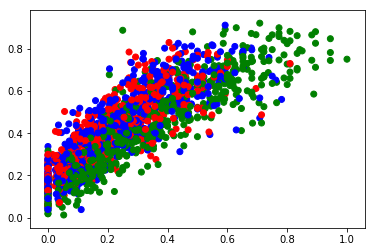

In [183]:
# Literal listener v2 eval results by conditions
plt.scatter(true_scores_grouped_cond, model_scores_grouped_cond, c=colors)
plt.show()